# Use the CUT&RUN model and the ChIP-seq model to predict on the union of all peaks

In [1]:
import os
os.chdir('/home/katie/bp_repo/reports/')

from util import import_shap_scores, import_peak_table, import_profiles, import_tfmodisco_results
from util import trim_motif_by_ic
from util import figure_to_vdom_image
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from IPython.display import display
import tqdm

import sys
sys.path.append('/home/katie/bp_repo/multitask_profile_model_SPI_GATA/')
from plotting_helper import *
from all_functions import *
from profile_models import ModelLoader

tqdm.tqdm_notebook()

plt.rcParams["figure.dpi"] = 130

/tmp/ipykernel_18704/3522789943.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm.tqdm_notebook()


0it [00:00, ?it/s]

## Does the ChIP-seq model predict equally strong peaks on the CUT&RUN-unique peaks vs. ChIP-seq-unique peaks vs. shared peaks?

### Preliminary data generating/loading

In [2]:
path = '/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/'

In [5]:
pd.read_csv(f'{path}CTCF_chip_unique_no_cut', sep='\t', header=None)

0          1          2      3      4  5          6           7   \
0      chr9  131739415  131740697     27  66768  .  803.80774  6676.80029   
1     chr17   38491975   38492361     45  51525  .  450.79672  5152.52783   
2      chr8    9830744    9831516    123  28151  .  242.43832  2815.10474   
3      chr6   11044262   11044934    150  26047  .  421.53549  2604.71802   
4      chr2  113602046  113602328    243  17697  .  313.94553  1769.78442   
...     ...        ...        ...    ...    ... ..        ...         ...   
4976   chrX  135438477  135438702  35795    192  .    9.35330    19.24553   
4977   chrX  151852335  151852641  35796    192  .    9.35330    19.24553   
4978   chrX   20127515   20127747  35797    192  .    9.35330    19.24553   
4979   chrX   30343321   30343492  35799    192  .    9.35330    19.24553   
4980   chrX   39134093   39134268  35800    192  .    9.35330    19.24553   

              8    9          10  
0     6670.64453  756  131740171  
1     5146.64307  247   38492222  
2     2809.70728  364    9831108  
3     2599.38306  313   11044575  
4     1764.70764  113  113602159  
...          ...  ...        ...  
4976    16.50112  112  135438589  
4977    16.50112  138  151852473  
4978    16.50112  145   20127660  
4979    16.50112   95   30343416  
4980    16.50112   95   39134188  

[4981 rows x 11 columns]

In [3]:
# Save preds using the CTCF ChIP-seq model!!
# YOU HAVE TO DO DATALOADING SEPARATELY BECAUSE THE TASKS_PATH WILL GET UPDATED (or ig you could update tasks_path in between uses...)

# Save predictions using model and BOTH assays' peaks
# note to self: using the DataLoader function ALREADY GETS RID OF CHRM AND CHRY!!

# model = ModelLoader('/home/katie/bp_repo/pipeline_outputs/ctcf_chipseq_feb7/' + 'model.state_dict', controls=True, num_tasks=1).load_model()
# path = '/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/'

# chip_unique_dataloader = DataLoader(tasks=['CTCF'], assay='chip-seq', controls=True, 
#                              tasks_path='/home/katie/bp_repo/research/data/chip-seq/', subset=['full'], 
#                              jitter=False, fake_controls=True,
#                              premade_tsv_path=f'{path}CTCF_chip_unique_no_cut').make_loaders()['full']

# save_preds(chip_unique_dataloader, model, 
# f'{path}CTCF_chip_model_unique_chip_loader_fake_controls.preds')

# chip_shared_dataloader = DataLoader(tasks=['CTCF'], assay='chip-seq', controls=True, 
#                              tasks_path='/home/katie/bp_repo/research/data/chip-seq/', subset=['full'], 
#                              jitter=False, fake_controls=True,
#                              premade_tsv_path=f'{path}CTCF_chip_unique_shared_cut').make_loaders()['full']


# save_preds(chip_shared_dataloader, model, 
# f'{path}CTCF_chip_model_shared_chip_loader_fake_controls.preds')

# cut_unique_dataloader = DataLoader(tasks=['CTCF'], assay='cutnrun', controls=True, 
#                              tasks_path='/home/katie/bp_repo/research/data/cutnrun/', subset=['full'], 
#                              jitter=False, fake_controls=True,
#                              premade_tsv_path=f'{path}CTCF_cut_unique_no_chip').make_loaders()['full']

# save_preds(cut_unique_dataloader, model, 
# f'{path}CTCF_chip_model_unique_cut_loader_fake_controls.preds')

# cut_shared_dataloader = DataLoader(tasks=['CTCF'], assay='cutnrun', controls=True, 
#                              tasks_path='/home/katie/bp_repo/research/data/cutnrun/', subset=['full'], 
#                              jitter=False, fake_controls=True,
#                              premade_tsv_path=f'{path}CTCF_cut_unique_shared_chip').make_loaders()['full']

# save_preds(cut_shared_dataloader, model, 
# f'{path}CTCF_chip_model_shared_cut_loader_fake_controls.preds')


CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_unique_shared_cut
(30821, 14)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/241 [00:00<?, ?it/s]

Saving result to HDF5...
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_unique_no_chip
(24246, 23)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'i1', 'i2', 'i3', 'i4', 'i5',
       'i6', 'i7', 'i8', 'i9', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/190 [00:00<?, ?it/s]

Saving result to HDF5...
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_unique_shared_chip
(29979, 23)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'i1', 'i2', 'i3', 'i4', 'i5',
       'i6', 'i7', 'i8', 'i9', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/235 [00:00<?, ?it/s]

Saving result to HDF5...


In [5]:
# Save preds using the CTCF CUT&RUN model!!
# YOU HAVE TO DO DATALOADING SEPARATELY BECAUSE THE TASKS_PATH WILL GET UPDATED (or ig you could update tasks_path in between uses...)

# Save predictions using model and BOTH assays' peaks
# note to self: using the DataLoader function ALREADY GETS RID OF CHRM AND CHRY!!

# model = ModelLoader('/home/katie/bp_repo/pipeline_outputs/ctcf_cutnrun_feb7/' + 'model.state_dict', controls=False, num_tasks=1).load_model()
# path = '/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/'

# chip_unique_dataloader = DataLoader(tasks=['CTCF'], assay='chip-seq', controls=False, 
#                              tasks_path='/home/katie/bp_repo/research/data/chip-seq/', subset=['full'], 
#                              jitter=False,
#                              premade_tsv_path=f'{path}CTCF_chip_unique_no_cut').make_loaders()['full']

# save_preds(chip_unique_dataloader, model, 
# f'{path}CTCF_cut_model_unique_chip_loader.preds')

# chip_shared_dataloader = DataLoader(tasks=['CTCF'], assay='chip-seq', controls=False, 
#                              tasks_path='/home/katie/bp_repo/research/data/chip-seq/', subset=['full'], 
#                              jitter=False,
#                              premade_tsv_path=f'{path}CTCF_chip_unique_shared_cut').make_loaders()['full']


# save_preds(chip_shared_dataloader, model, 
# f'{path}CTCF_cut_model_shared_chip_loader.preds')

# cut_unique_dataloader = DataLoader(tasks=['CTCF'], assay='cutnrun', controls=False, 
#                              tasks_path='/home/katie/bp_repo/research/data/cutnrun/', subset=['full'], 
#                              jitter=False,
#                              premade_tsv_path=f'{path}CTCF_cut_unique_no_chip').make_loaders()['full']

# save_preds(cut_unique_dataloader, model, 
# f'{path}CTCF_cut_model_unique_cut_loader.preds')

# cut_shared_dataloader = DataLoader(tasks=['CTCF'], assay='cutnrun', controls=False, 
#                              tasks_path='/home/katie/bp_repo/research/data/cutnrun/', subset=['full'], 
#                              jitter=False,
#                              premade_tsv_path=f'{path}CTCF_cut_unique_shared_chip').make_loaders()['full']

# save_preds(cut_shared_dataloader, model, 
# f'{path}CTCF_cut_model_shared_cut_loader.preds')


CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_unique_no_cut
(4980, 14)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/39 [00:00<?, ?it/s]

Saving result to HDF5...
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_unique_shared_cut
(30821, 14)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/241 [00:00<?, ?it/s]

Saving result to HDF5...
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_unique_no_chip
(24246, 23)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'i1', 'i2', 'i3', 'i4', 'i5',
       'i6', 'i7', 'i8', 'i9', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/190 [00:00<?, ?it/s]

Saving result to HDF5...
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_unique_shared_chip
(29979, 23)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'i1', 'i2', 'i3', 'i4', 'i5',
       'i6', 'i7', 'i8', 'i9', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/235 [00:00<?, ?it/s]

Saving result to HDF5...


In [3]:
# Generate/load new unique vs shared peaks files
# i don't feel like using the old ones because those contain the chrY and chrM peaks which are hard to deal with

# first, save the peaks files without the chrY and chrM peaks

# # load in peaks
# chip_peaks = import_peak_table(['/home/katie/bp_repo/research/data/chip-seq/CTCF/CTCF.bed'])
# cut_peaks = import_peak_table(['/home/katie/bp_repo/research/data/cutnrun/CTCF/CTCF.bed'])

# # get rid of chrY and chrM peaks
# chip_peaks = chip_peaks.loc[chip_peaks.chrom != 'chrY']
# cut_peaks = cut_peaks.loc[cut_peaks.chrom != 'chrM']

# # clean the dataframe a little bit
# chip_peaks.reset_index(inplace=True, drop=True)
# cut_peaks.reset_index(inplace=True, drop=True)
# chip_peaks.name = chip_peaks.index  # fix weird peak column
# cut_peaks.name = cut_peaks.index # add peak column
# cut_peaks.drop('i9', axis=1, inplace=True)  # remove the i9 column to bring the dataframe down to 20 columns, for import_peak_table()

# chip_peaks.to_csv('/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_peaks_no_chrY', sep='\t', index=False)
# cut_peaks.to_csv('/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_peaks_no_chrM', sep='\t', index=False)

chip_peaks = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_peaks_no_chrY', sep='\t')
cut_peaks = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_peaks_no_chrM', sep='\t')

In [2]:
# Generate/load unique vs shared peaks
# !bedtools intersect -v -a /home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_peaks_no_chrY -b /home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_peaks_no_chrM > /home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_unique_no_cut
# !bedtools intersect -v -a /home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_peaks_no_chrM -b /home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_peaks_no_chrY > /home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_unique_no_chip
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_peaks_no_chrY -b /home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_peaks_no_chrM > /home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_unique_shared_cut
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_peaks_no_chrM -b /home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_peaks_no_chrY > /home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_unique_shared_chip

# btw: unique peaks U shared peaks = all peaks (you can check!)
chip_unique_peaks = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_unique_no_cut'])
cut_unique_peaks = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_unique_no_chip'])
chip_shared_peaks = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_unique_shared_cut'])
cut_shared_peaks = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_unique_shared_chip'])


In [3]:
# Load in ChIP-seq model predictions
chip_model_unique_chip_preds = h5py.File('/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_model_unique_chip_loader_fake_controls.preds','r')
chip_model_shared_chip_preds = h5py.File('/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_model_shared_chip_loader_fake_controls.preds','r')
chip_model_unique_cut_preds = h5py.File('/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_model_unique_cut_loader_fake_controls.preds','r')
chip_model_shared_cut_preds = h5py.File('/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_model_shared_cut_loader_fake_controls.preds','r')

# Find the duplicate indexes so i can subset all of my preds/counts arrays
chip_model_unique_chip_coords = pd.DataFrame({'chrom': chip_model_unique_chip_preds['coords']['coords_chrom'], 
                  'start': chip_model_unique_chip_preds['coords']['coords_start'],
                  'end': chip_model_unique_chip_preds['coords']['coords_end']})
chip_model_unique_chip_coords.chrom = [i.decode('utf-8') for i in chip_model_unique_chip_coords.chrom]  # change from binary string thingy to utf-8 encoded

chip_model_shared_chip_coords = pd.DataFrame({'chrom': chip_model_shared_chip_preds['coords']['coords_chrom'], 
                  'start': chip_model_shared_chip_preds['coords']['coords_start'],
                  'end': chip_model_shared_chip_preds['coords']['coords_end']})
chip_model_shared_chip_coords.chrom = [i.decode('utf-8') for i in chip_model_shared_chip_coords.chrom]

chip_model_unique_cut_coords = pd.DataFrame({'chrom': chip_model_unique_cut_preds['coords']['coords_chrom'], 
                  'start': chip_model_unique_cut_preds['coords']['coords_start'],
                  'end': chip_model_unique_cut_preds['coords']['coords_end']})
chip_model_unique_cut_coords.chrom = [i.decode('utf-8') for i in chip_model_unique_cut_coords.chrom]

chip_model_shared_cut_coords = pd.DataFrame({'chrom': chip_model_shared_cut_preds['coords']['coords_chrom'], 
                  'start': chip_model_shared_cut_preds['coords']['coords_start'],
                  'end': chip_model_shared_cut_preds['coords']['coords_end']})
chip_model_shared_cut_coords.chrom = [i.decode('utf-8') for i in chip_model_shared_cut_coords.chrom]

chip_model_unique_chip_dups = chip_model_unique_chip_coords.duplicated()  # boolean array indicating whether a row is a duplicate
chip_model_shared_chip_dups = chip_model_shared_chip_coords.duplicated()
chip_model_unique_cut_dups = chip_model_unique_cut_coords.duplicated()    
chip_model_shared_cut_dups = chip_model_shared_cut_coords.duplicated()



In [4]:
# Load in CUT&RUN model predictions
cut_model_unique_chip_preds = h5py.File('/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_model_unique_chip_loader.preds','r')
cut_model_shared_chip_preds = h5py.File('/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_model_shared_chip_loader.preds','r')
cut_model_unique_cut_preds = h5py.File('/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_model_unique_cut_loader.preds','r')
cut_model_shared_cut_preds = h5py.File('/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_model_shared_cut_loader.preds','r')

# Find the duplicate indexes so i can subset all of my preds/counts arrays
cut_model_unique_chip_coords = pd.DataFrame({'chrom': cut_model_unique_chip_preds['coords']['coords_chrom'], 
                  'start': cut_model_unique_chip_preds['coords']['coords_start'],
                  'end': cut_model_unique_chip_preds['coords']['coords_end']})
cut_model_unique_chip_coords.chrom = [i.decode('utf-8') for i in cut_model_unique_chip_coords.chrom]  # change from binary string thingy to utf-8 encoded

cut_model_shared_chip_coords = pd.DataFrame({'chrom': cut_model_shared_chip_preds['coords']['coords_chrom'], 
                  'start': cut_model_shared_chip_preds['coords']['coords_start'],
                  'end': cut_model_shared_chip_preds['coords']['coords_end']})
cut_model_shared_chip_coords.chrom = [i.decode('utf-8') for i in cut_model_shared_chip_coords.chrom]


cut_model_unique_cut_coords = pd.DataFrame({'chrom': cut_model_unique_cut_preds['coords']['coords_chrom'], 
                  'start': cut_model_unique_cut_preds['coords']['coords_start'],
                  'end': cut_model_unique_cut_preds['coords']['coords_end']})
cut_model_unique_cut_coords.chrom = [i.decode('utf-8') for i in cut_model_unique_cut_coords.chrom]

cut_model_shared_cut_coords = pd.DataFrame({'chrom': cut_model_shared_cut_preds['coords']['coords_chrom'], 
                  'start': cut_model_shared_cut_preds['coords']['coords_start'],
                  'end': cut_model_shared_cut_preds['coords']['coords_end']})
cut_model_shared_cut_coords.chrom = [i.decode('utf-8') for i in cut_model_shared_cut_coords.chrom]

cut_model_unique_chip_dups = cut_model_unique_chip_coords.duplicated()  # boolean array indicating whether a row is a duplicate
cut_model_shared_chip_dups = cut_model_shared_chip_coords.duplicated()
cut_model_unique_cut_dups = cut_model_unique_cut_coords.duplicated()    
cut_model_shared_cut_dups = cut_model_shared_cut_coords.duplicated()



In [5]:
# Subset predictions to the unique rows
chip_model_unique_pred_profs_chip = np.exp(np.array(chip_model_unique_chip_preds['predictions']['log_pred_profs']))[chip_model_unique_chip_dups]  # each row corresponds to unique peak
chip_model_unique_pred_profs_cut = np.exp(np.array(chip_model_unique_cut_preds['predictions']['log_pred_profs']))[chip_model_unique_cut_dups]
chip_model_unique_pred_counts_chip = np.exp(np.array(chip_model_unique_chip_preds['predictions']['log_pred_counts']))[chip_model_unique_chip_dups]
chip_model_unique_pred_counts_cut = np.exp(np.array(chip_model_unique_cut_preds['predictions']['log_pred_counts']))[chip_model_unique_cut_dups]

chip_model_shared_pred_profs_chip = np.exp(np.array(chip_model_shared_chip_preds['predictions']['log_pred_profs']))[chip_model_shared_chip_dups]  # each row corresponds to shared peak
chip_model_shared_pred_profs_cut = np.exp(np.array(chip_model_shared_cut_preds['predictions']['log_pred_profs']))[chip_model_shared_cut_dups]
chip_model_shared_pred_counts_chip = np.exp(np.array(chip_model_shared_chip_preds['predictions']['log_pred_counts']))[chip_model_shared_chip_dups]
chip_model_shared_pred_counts_cut = np.exp(np.array(chip_model_shared_cut_preds['predictions']['log_pred_counts']))[chip_model_shared_cut_dups]


cut_model_unique_pred_profs_chip = np.exp(np.array(cut_model_unique_chip_preds['predictions']['log_pred_profs']))[cut_model_unique_chip_dups]  # each row corresponds to unique peak
cut_model_unique_pred_profs_cut = np.exp(np.array(cut_model_unique_cut_preds['predictions']['log_pred_profs']))[cut_model_unique_cut_dups]
cut_model_unique_pred_counts_chip = np.exp(np.array(cut_model_unique_chip_preds['predictions']['log_pred_counts']))[cut_model_unique_chip_dups]
cut_model_unique_pred_counts_cut = np.exp(np.array(cut_model_unique_cut_preds['predictions']['log_pred_counts']))[cut_model_unique_cut_dups]

cut_model_shared_pred_profs_chip = np.exp(np.array(cut_model_shared_chip_preds['predictions']['log_pred_profs']))[cut_model_shared_chip_dups]  # each row corresponds to shared peak
cut_model_shared_pred_profs_cut = np.exp(np.array(cut_model_shared_cut_preds['predictions']['log_pred_profs']))[cut_model_shared_cut_dups]
cut_model_shared_pred_counts_chip = np.exp(np.array(cut_model_shared_chip_preds['predictions']['log_pred_counts']))[cut_model_shared_chip_dups]
cut_model_shared_pred_counts_cut = np.exp(np.array(cut_model_shared_cut_preds['predictions']['log_pred_counts']))[cut_model_shared_cut_dups]


In [6]:
# Load in true profiles/counts (can use the same chip_preds and cut_preds hdf5s loaded in 2 cells earlier) and
# subset true profs/counts to the unique rows
true_profs_chip = np.array(chip_model_chip_preds['predictions']['true_profs'])[chip_model_chip_dups]  # each row corresponds to unique peak
true_profs_cut = np.array(chip_model_cut_preds['predictions']['true_profs'])[chip_model_cut_dups]
true_counts_chip = np.array(chip_model_chip_preds['predictions']['true_counts'])[chip_model_chip_dups]
true_counts_cut = np.array(chip_model_cut_preds['predictions']['true_counts'])[chip_model_cut_dups]

# NOTE!! you can also load in true profs/counts using the cut model preds because the true stuff is obviously always the SAME
# i checked and YES they do load in the same... you just have to make sure the predictions are NOT JITTERED

NameError: name 'chip_model_chip_preds' is not defined

### Subset predictions and true profs/counts to unique vs. shared peaks

In [8]:
# Get the peak indexes for the unique and shared peaks. These can be used to directly index into preds/coords arrays
chip_unique_inds = list(chip_unique_peaks.name)
chip_shared_inds = list(chip_shared_peaks.name)
cut_unique_inds = list(cut_unique_peaks.name)
cut_shared_inds = list(cut_shared_peaks.name)

In [9]:
# Subset the predicted profiles and counts to the unique and shared indexes
pred_profs_chip_unique = pred_profs_chip[chip_unique_inds]
pred_profs_cut_unique = pred_profs_cut[cut_unique_inds]
pred_profs_chip_shared = pred_profs_chip[chip_shared_inds]
pred_profs_cut_shared = pred_profs_cut[cut_shared_inds]

pred_counts_chip_unique = pred_counts_chip[chip_unique_inds]
pred_counts_cut_unique = pred_counts_cut[cut_unique_inds]
pred_counts_chip_shared = pred_counts_chip[chip_shared_inds]
pred_counts_cut_shared = pred_counts_cut[cut_shared_inds]

# Subset the true profiles and counts to the unique and shared indexes
true_profs_chip_unique = true_profs_chip[chip_unique_inds]
true_profs_cut_unique = true_profs_cut[cut_unique_inds]
true_profs_chip_shared = true_profs_chip[chip_shared_inds]
true_profs_cut_shared = true_profs_cut[cut_shared_inds]

true_counts_chip_unique = true_counts_chip[chip_unique_inds]
true_counts_cut_unique = true_counts_cut[cut_unique_inds]
true_counts_chip_shared = true_counts_chip[chip_shared_inds]
true_counts_cut_shared = true_counts_cut[cut_shared_inds]

## Analyze!

### Profile JSDs and plotting distribution across peaks

In [7]:
from profile_performance import profile_jsd

In [8]:
# need smooth_true_profs=False to ensure symmetry (i.e., same if you do chip model then cut or vice versa!)
unique_chip_jsds = profile_jsd(cut_model_unique_pred_profs_chip, chip_model_unique_pred_profs_chip, 
           prof_smooth_kernel_sigma=7, prof_smooth_kernel_width=81, smooth_true_profs=False)

shared_chip_jsds = profile_jsd(cut_model_shared_pred_profs_chip, chip_model_shared_pred_profs_chip, 
           prof_smooth_kernel_sigma=7, prof_smooth_kernel_width=81, smooth_true_profs=False)

unique_cut_jsds = profile_jsd(cut_model_unique_pred_profs_cut, chip_model_unique_pred_profs_cut, 
           prof_smooth_kernel_sigma=7, prof_smooth_kernel_width=81, smooth_true_profs=False)

shared_cut_jsds = profile_jsd(cut_model_shared_pred_profs_cut, chip_model_shared_pred_profs_cut, 
           prof_smooth_kernel_sigma=7, prof_smooth_kernel_width=81, smooth_true_profs=False)

Text(0.5, 1.0, 'JSDs for CUT&RUN model and ChIP-seq model\non ChIP-seq unique peaks')

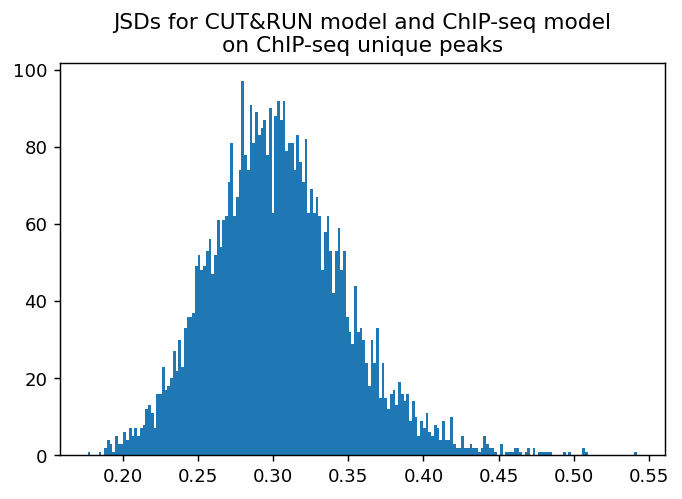

In [45]:
fig = plt.hist(unique_chip_jsds[:], bins=200)
plt.title('JSDs for CUT&RUN model and ChIP-seq model\non ChIP-seq unique peaks')

Text(0.5, 1.0, 'JSDs for CUT&RUN model and ChIP-seq model\non ChIP-seq shared peaks')

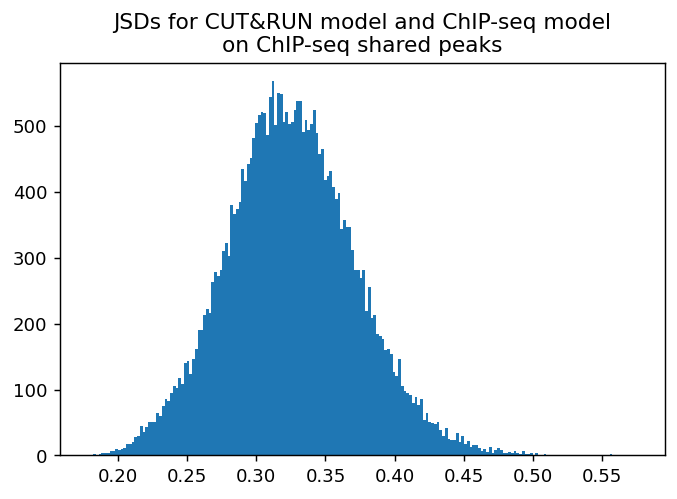

In [46]:
fig = plt.hist(shared_chip_jsds[:], bins=200)
plt.title('JSDs for CUT&RUN model and ChIP-seq model\non ChIP-seq shared peaks')

Text(0.5, 1.0, 'JSDs for CUT&RUN model and ChIP-seq model\non CUT&RUN unique peaks')

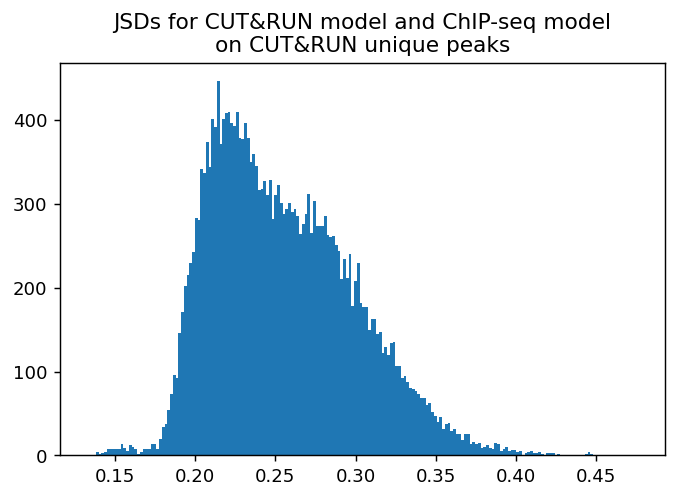

In [47]:
fig = plt.hist(unique_cut_jsds[:], bins=200)
plt.title('JSDs for CUT&RUN model and ChIP-seq model\non CUT&RUN unique peaks')

Text(0.5, 1.0, 'JSDs for CUT&RUN model and ChIP-seq model\non CUT&RUN shared peaks')

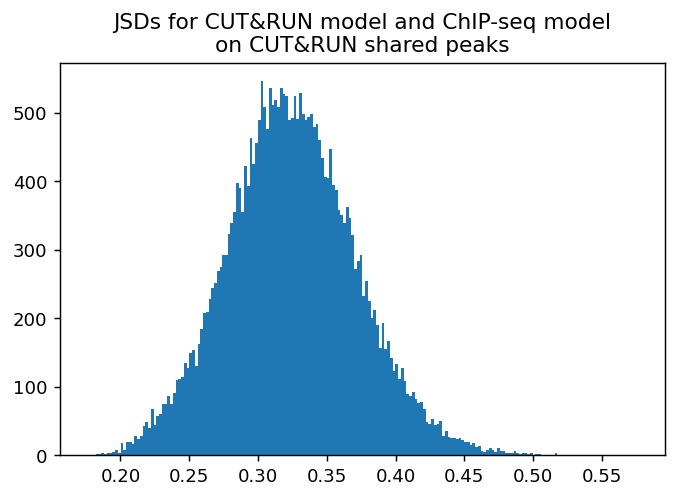

In [48]:
fig = plt.hist(shared_cut_jsds[:], bins=200)
plt.title('JSDs for CUT&RUN model and ChIP-seq model\non CUT&RUN shared peaks')

### Profile MSDs and plotting distribution across peaks

mean squared difference

In [9]:
unique_chip_msds = np.mean(np.square(cut_model_unique_pred_counts_chip - chip_model_unique_pred_counts_chip), axis=2)

shared_chip_msds = np.mean(np.square(cut_model_shared_pred_counts_chip - chip_model_shared_pred_counts_chip), axis=2)

unique_cut_msds = np.mean(np.square(cut_model_unique_pred_counts_cut - chip_model_unique_pred_counts_cut), axis=2)

shared_cut_msds = np.mean(np.square(cut_model_shared_pred_counts_cut - chip_model_shared_pred_counts_cut), axis=2)



Text(0.5, 1.0, 'MSEs for CUT&RUN model and ChIP-seq model\non ChIP-seq unique peaks')

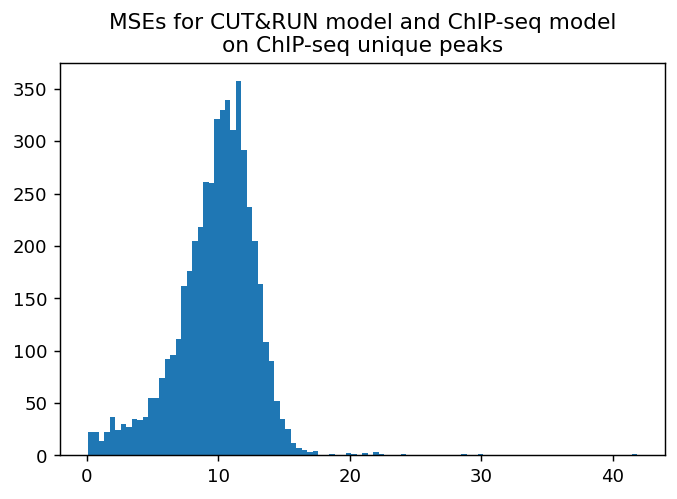

In [10]:
fig = plt.hist(unique_chip_msds[:], bins=100)
plt.title('MSEs for CUT&RUN model and ChIP-seq model\non ChIP-seq unique peaks')

Text(0.5, 1.0, 'MSEs for CUT&RUN model and ChIP-seq model\non ChIP-seq shared peaks')

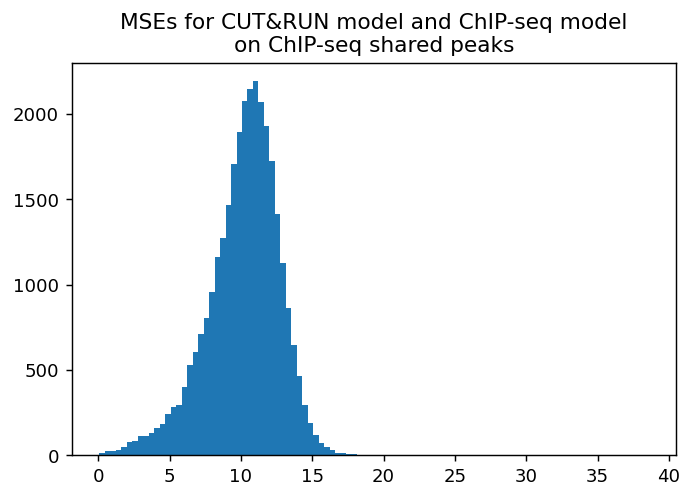

In [11]:
fig = plt.hist(shared_chip_msds[:], bins=100)
plt.title('MSEs for CUT&RUN model and ChIP-seq model\non ChIP-seq shared peaks')

Text(0.5, 1.0, 'MSEs for CUT&RUN model and ChIP-seq model\non CUT&RUN unique peaks')

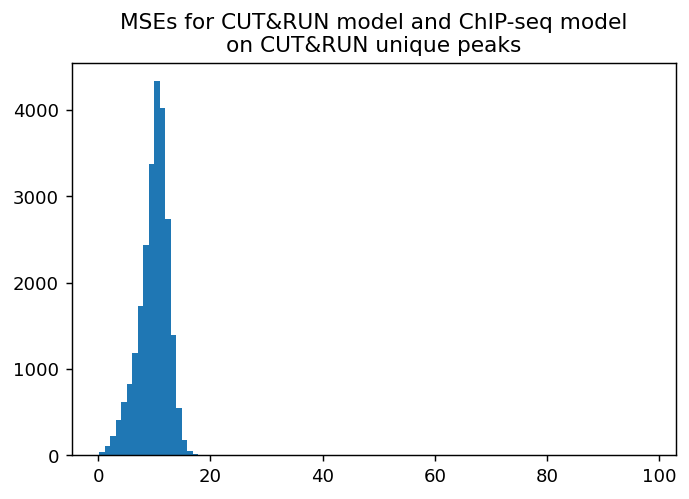

In [12]:
fig = plt.hist(unique_cut_msds[:], bins=100)
plt.title('MSEs for CUT&RUN model and ChIP-seq model\non CUT&RUN unique peaks')

Text(0.5, 1.0, 'MSEs for CUT&RUN model and ChIP-seq model\non CUT&RUN shared peaks')

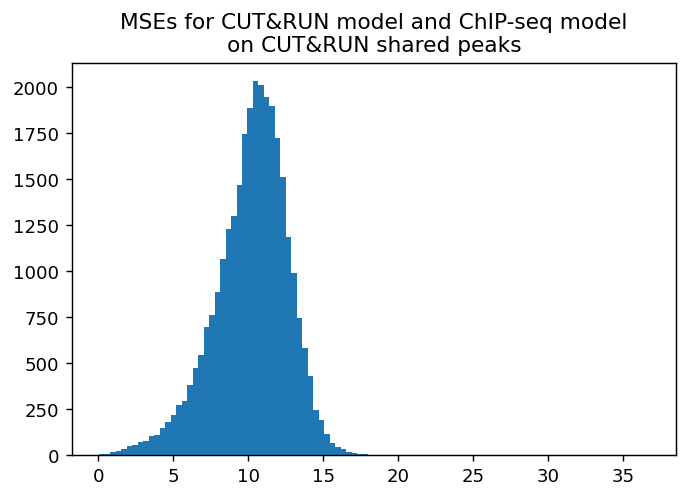

In [13]:
fig = plt.hist(shared_cut_msds[:], bins=100)
plt.title('MSEs for CUT&RUN model and ChIP-seq model\non CUT&RUN shared peaks')

### Rank peaks by JSD and show examples of similarly/differently predicted peaks

In [98]:
ranked_jsd_unique_chip_inds = np.argsort(unique_chip_jsds.reshape(-1))  # inds that sort unique_chip_jsds from small to big jsds
ranked_jsd_shared_chip_inds = np.argsort(shared_chip_jsds.reshape(-1))
ranked_jsd_unique_cut_inds = np.argsort(unique_cut_jsds.reshape(-1)) 
ranked_jsd_shared_cut_inds = np.argsort(shared_cut_jsds.reshape(-1)) 

In [135]:
# these pred profiles are ordered from smallest jsd to largest
ranked_jsd_unique_pred_profs_chip = {'cut': cut_model_unique_pred_profs_chip[ranked_jsd_unique_chip_inds], 
                          'chip': chip_model_unique_pred_profs_chip[ranked_jsd_unique_chip_inds]}

ranked_jsd_shared_pred_profs_chip = {'cut': cut_model_shared_pred_profs_chip[ranked_jsd_shared_chip_inds], 
                          'chip': chip_model_shared_pred_profs_chip[ranked_jsd_shared_chip_inds]}

ranked_jsd_unique_pred_profs_cut = {'cut': cut_model_unique_pred_profs_cut[ranked_jsd_unique_cut_inds], 
                          'chip': chip_model_unique_pred_profs_cut[ranked_jsd_unique_cut_inds]}

ranked_jsd_shared_pred_profs_cut = {'cut': cut_model_shared_pred_profs_cut[ranked_jsd_shared_cut_inds], 
                          'chip': chip_model_shared_pred_profs_cut[ranked_jsd_shared_cut_inds]}

# these pred counts are indexed same as above
ranked_jsd_unique_pred_counts_chip = {'cut': cut_model_unique_pred_counts_chip[ranked_jsd_unique_chip_inds], 
                          'chip': chip_model_unique_pred_counts_chip[ranked_jsd_unique_chip_inds]}

ranked_jsd_shared_pred_counts_chip = {'cut': cut_model_shared_pred_counts_chip[ranked_jsd_shared_chip_inds], 
                          'chip': chip_model_shared_pred_counts_chip[ranked_jsd_shared_chip_inds]}

ranked_jsd_unique_pred_counts_cut = {'cut': cut_model_unique_pred_counts_cut[ranked_jsd_unique_cut_inds], 
                          'chip': chip_model_unique_pred_counts_cut[ranked_jsd_unique_cut_inds]}

ranked_jsd_shared_pred_counts_cut = {'cut': cut_model_shared_pred_counts_cut[ranked_jsd_shared_cut_inds], 
                          'chip': chip_model_shared_pred_counts_cut[ranked_jsd_shared_cut_inds]}

In [132]:
def plot(pred_profs, pred_counts, index, task, titles=True):
    fig, ax = plt.subplots(1, figsize=(15, 4))
    if titles:
        plt.suptitle(f'Task: {task}, Index: {index}')
    ax.plot(pred_profs[index, 0,:,0] * pred_counts[0][0][0], color="royalblue")
    ax.plot(-pred_profs[index, 0,:,1] * pred_counts[0][0][1], color="goldenrod")

In [133]:
def plot_from_model_dicts(pred_profs_dict, pred_counts_dict, indexes, task):
    ''' takes dicts with keys `cut` and `chip` corresponding to preds for same subset of peaks, under different models 
        also takes list of indexes to plot '''
    for i in indexes:
        plot(pred_profs_dict['cut'], pred_counts_dict['cut'], i, 'CUT&RUN model on ' + task)
        plot(pred_profs_dict['chip'], pred_counts_dict['chip'], i, 'ChIP-seq model on ' + task)

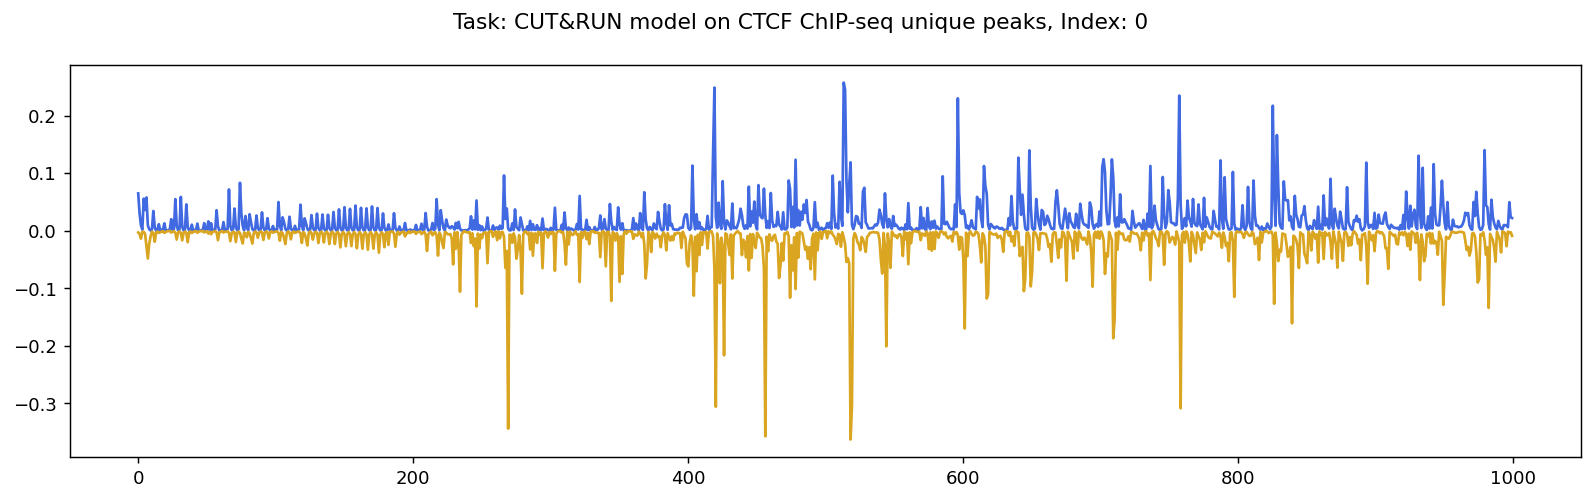

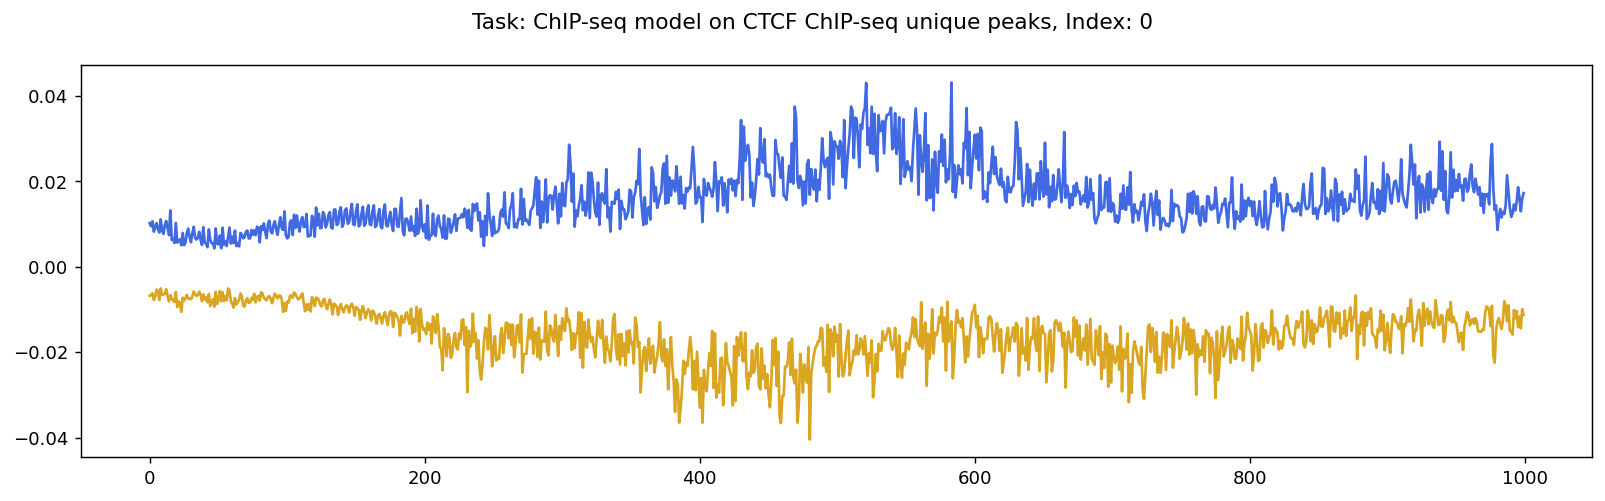

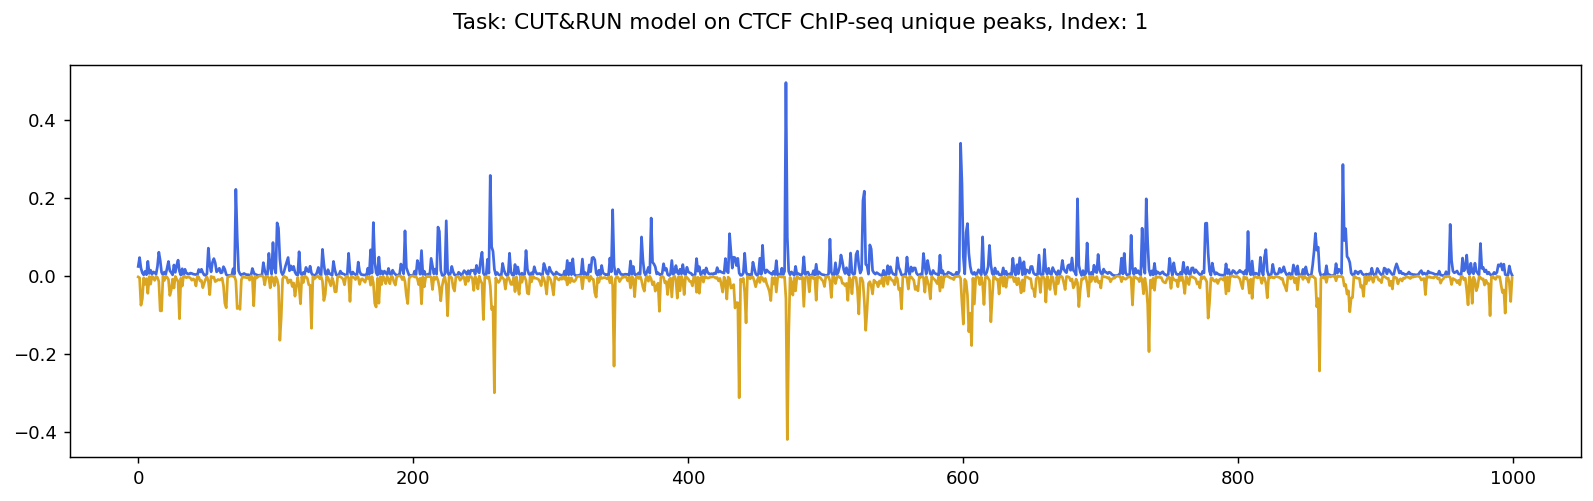

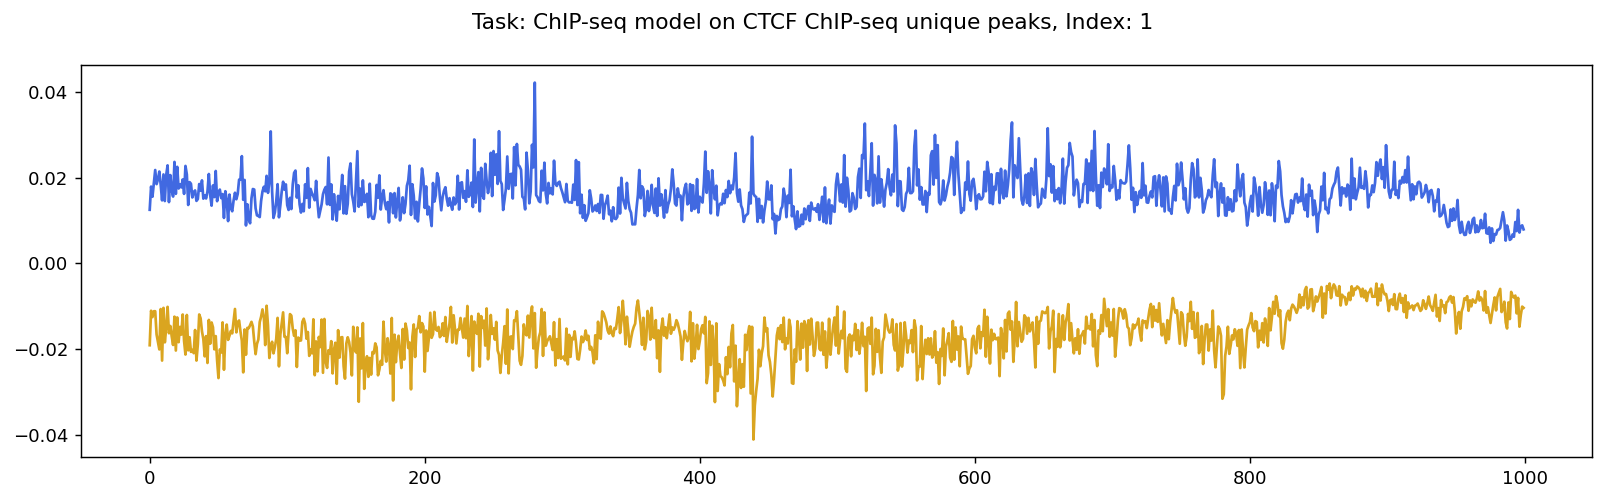

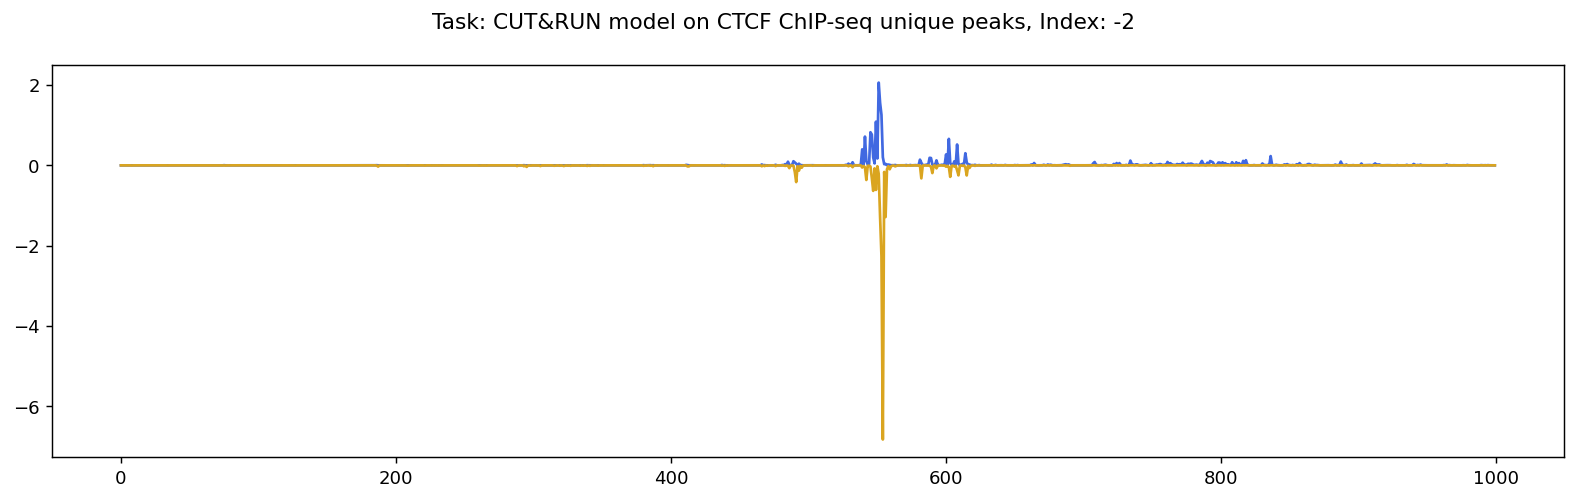

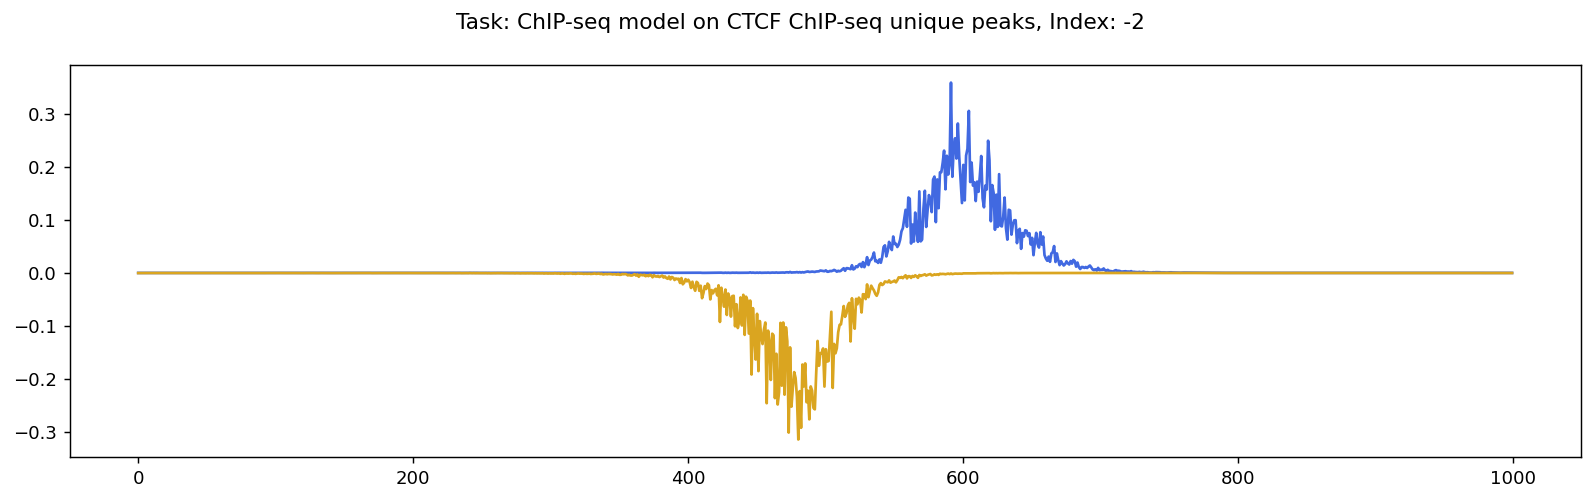

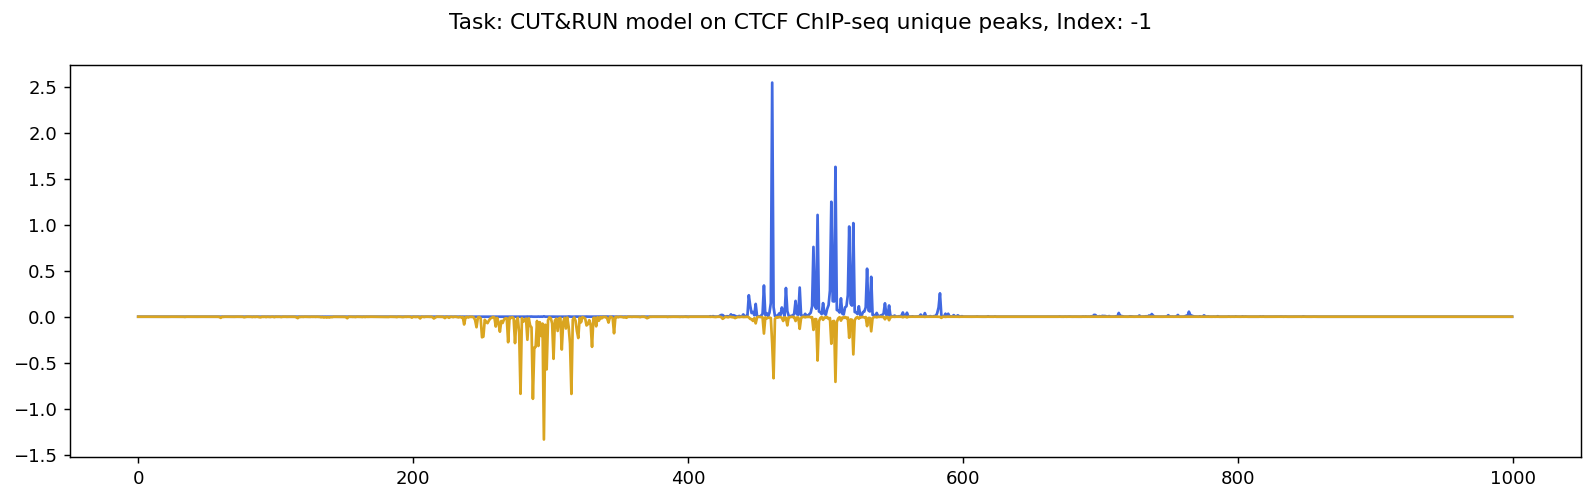

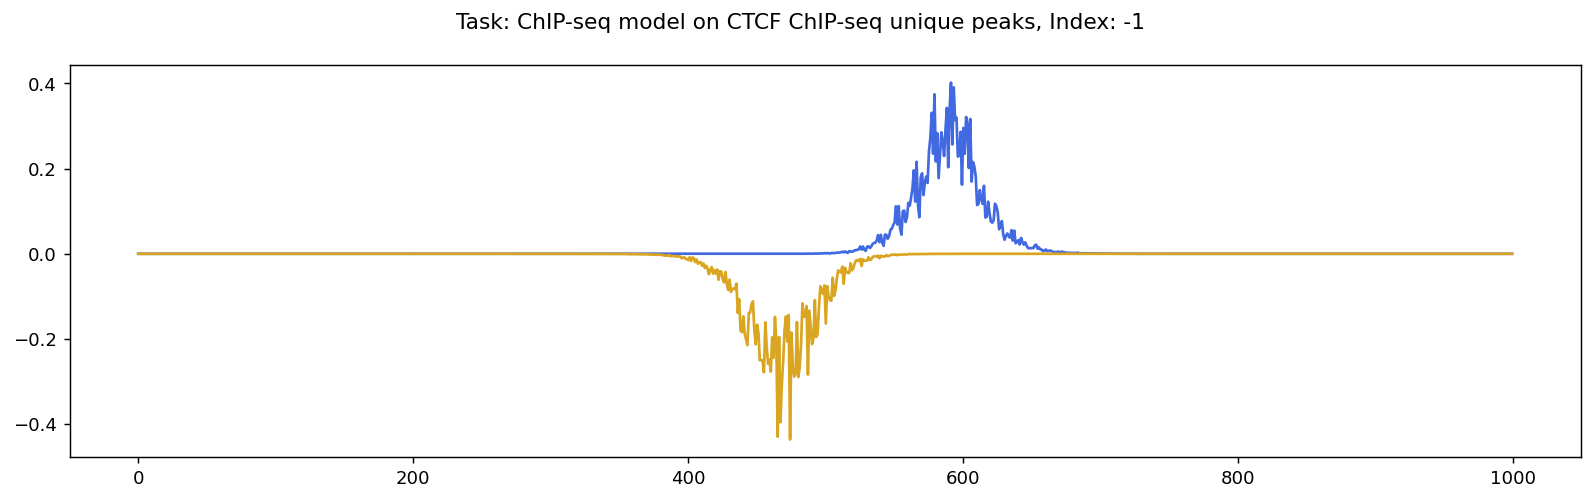

In [145]:
plot_from_model_dicts(ranked_jsd_unique_pred_profs_chip, ranked_jsd_unique_pred_counts_chip, list(range(2)), 
                      'CTCF ChIP-seq unique peaks')
plot_from_model_dicts(ranked_jsd_unique_pred_profs_chip, ranked_jsd_unique_pred_counts_chip, list(range(-2,0)), 
                      'CTCF ChIP-seq unique peaks')

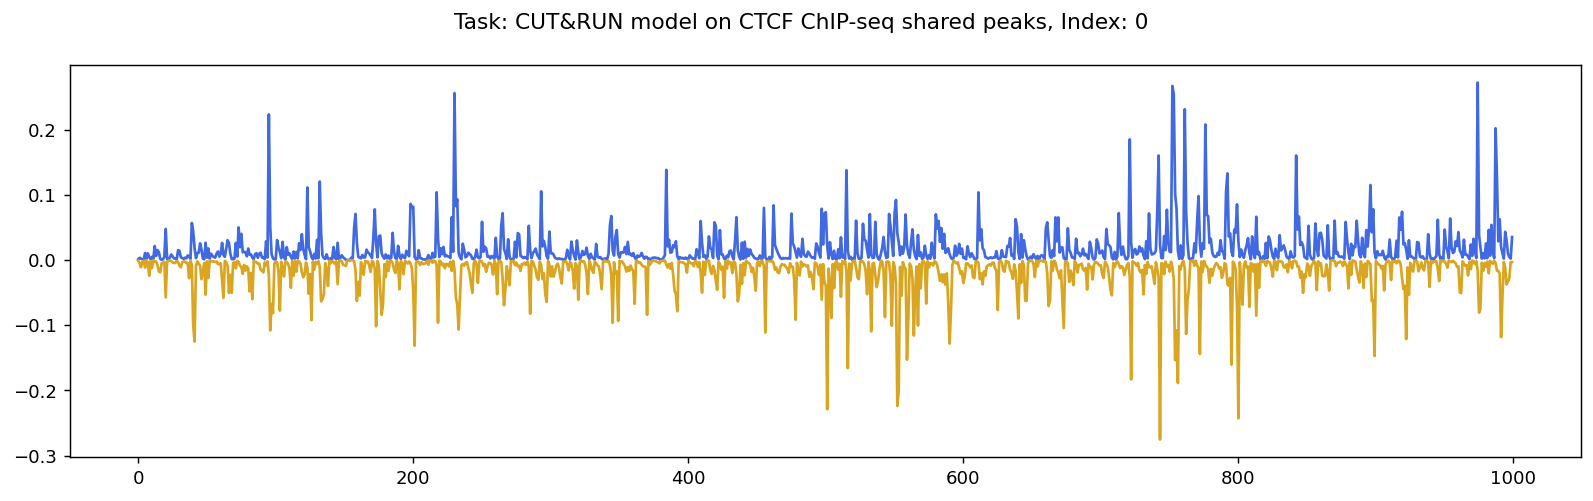

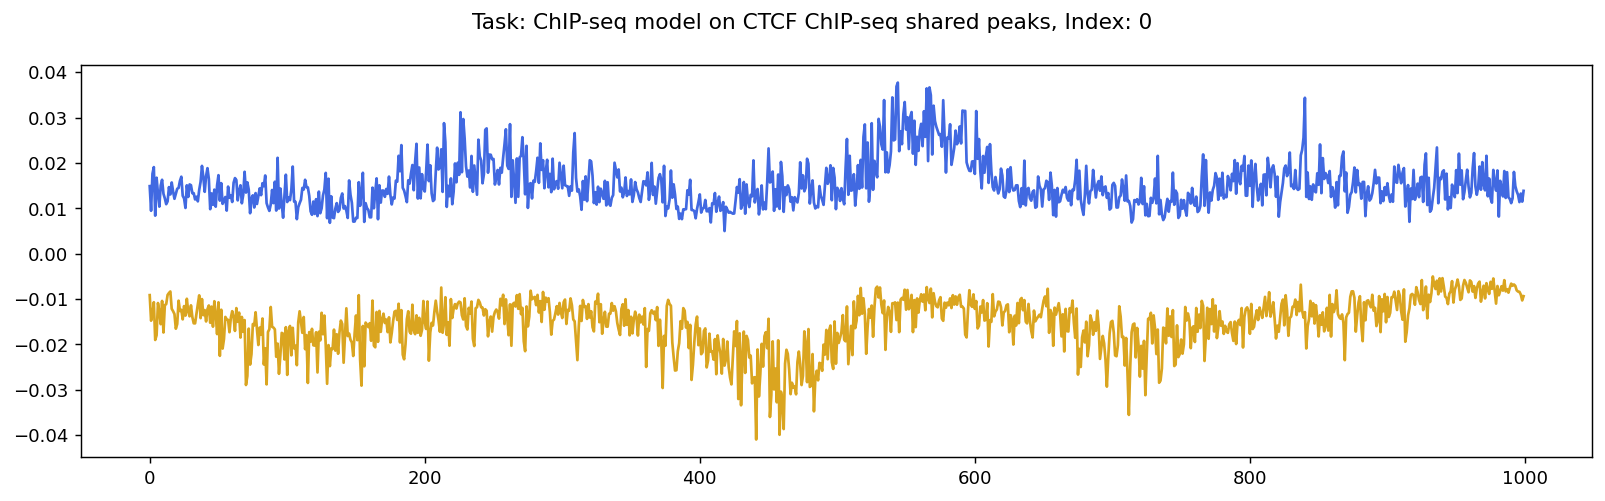

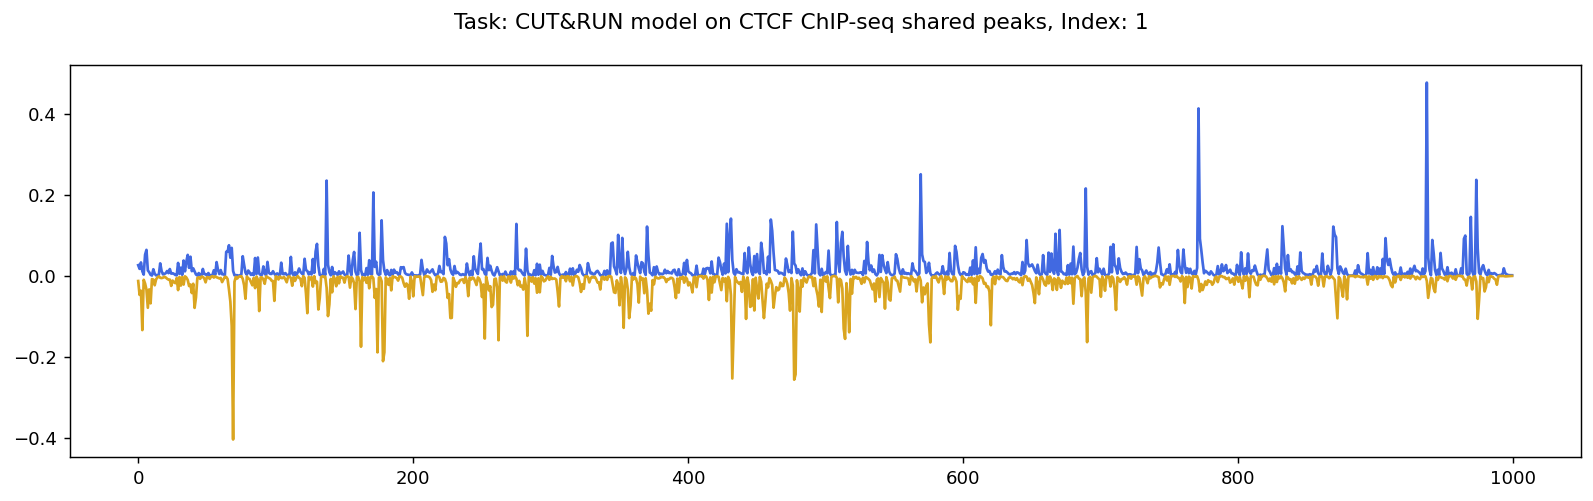

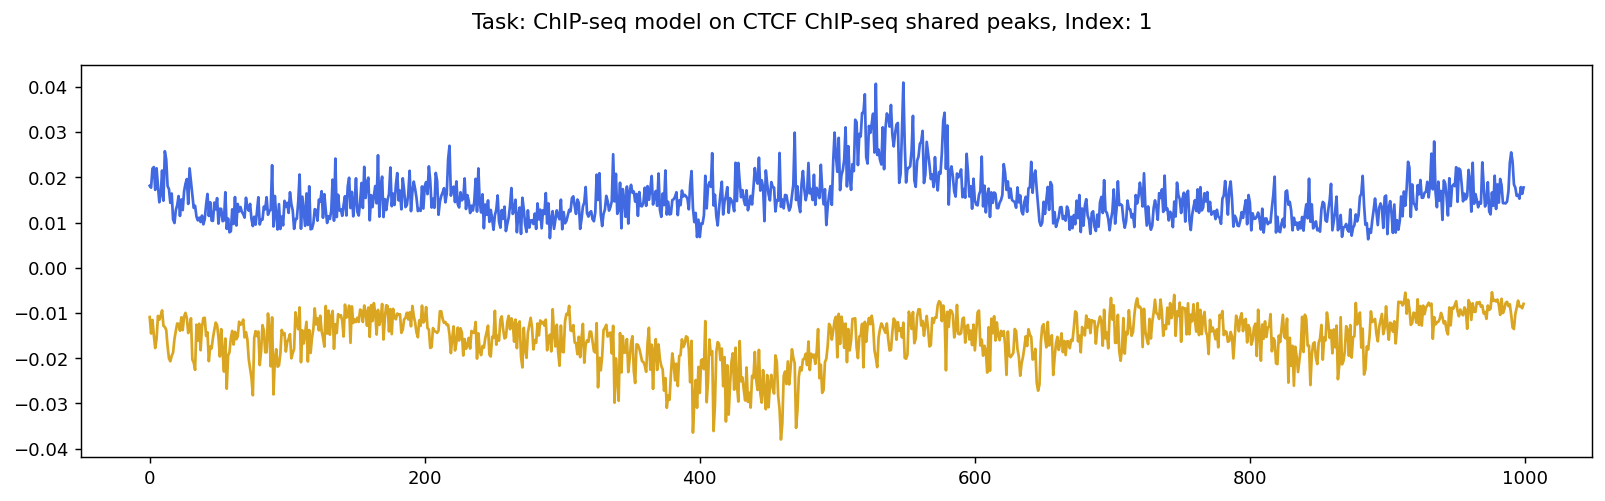

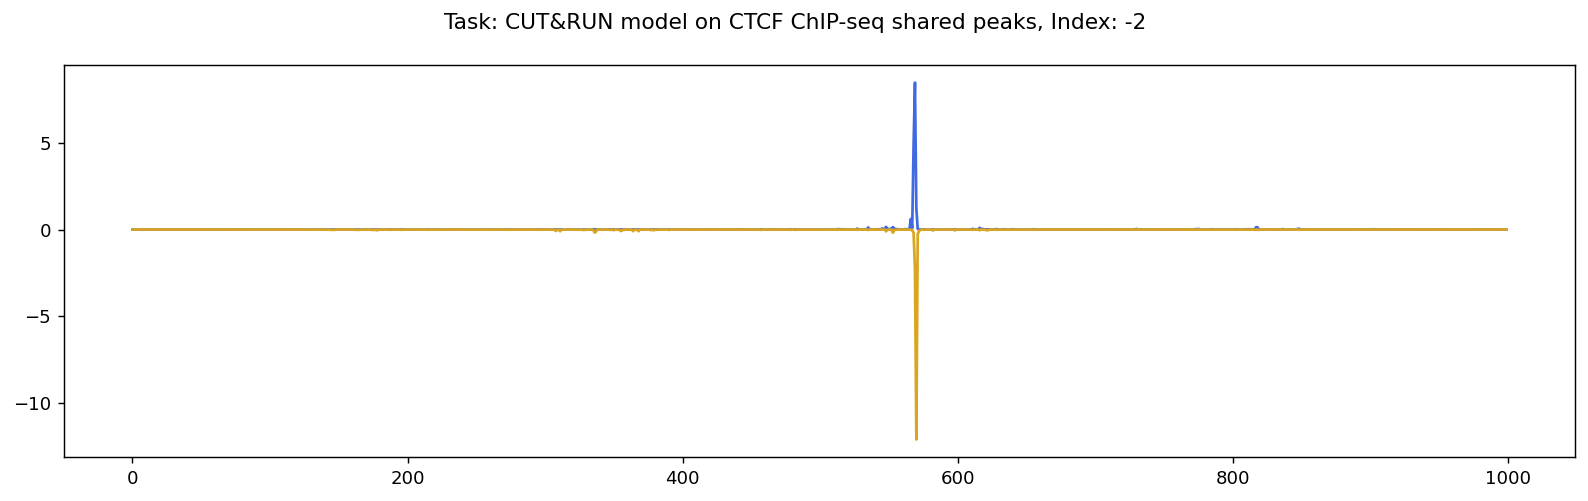

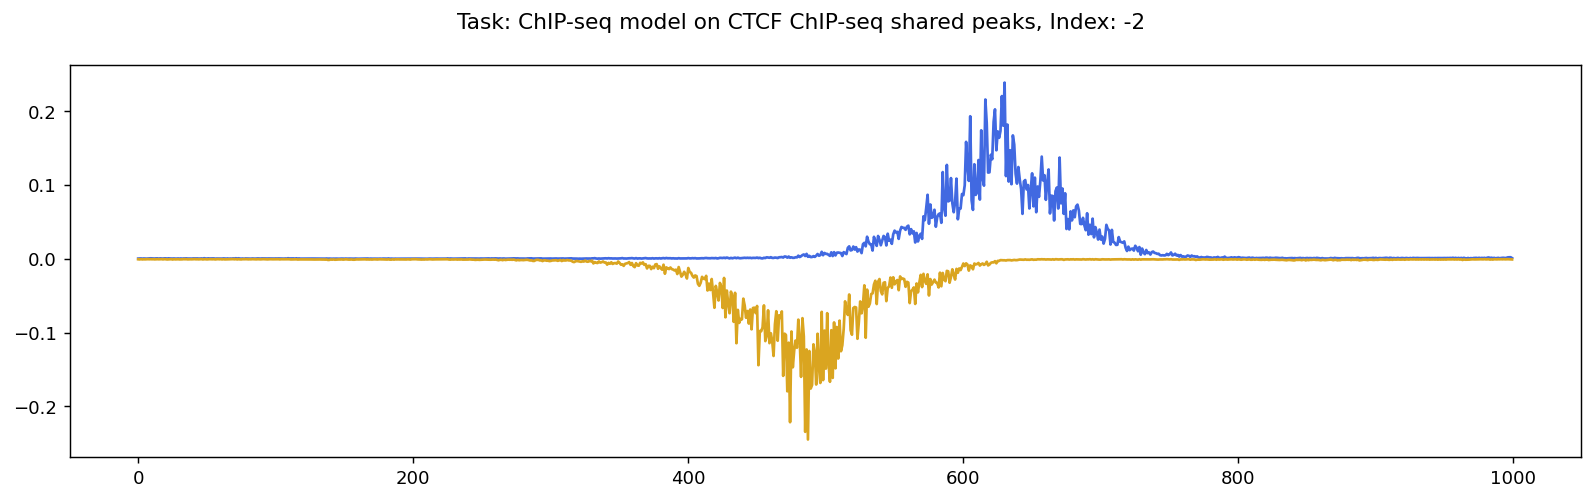

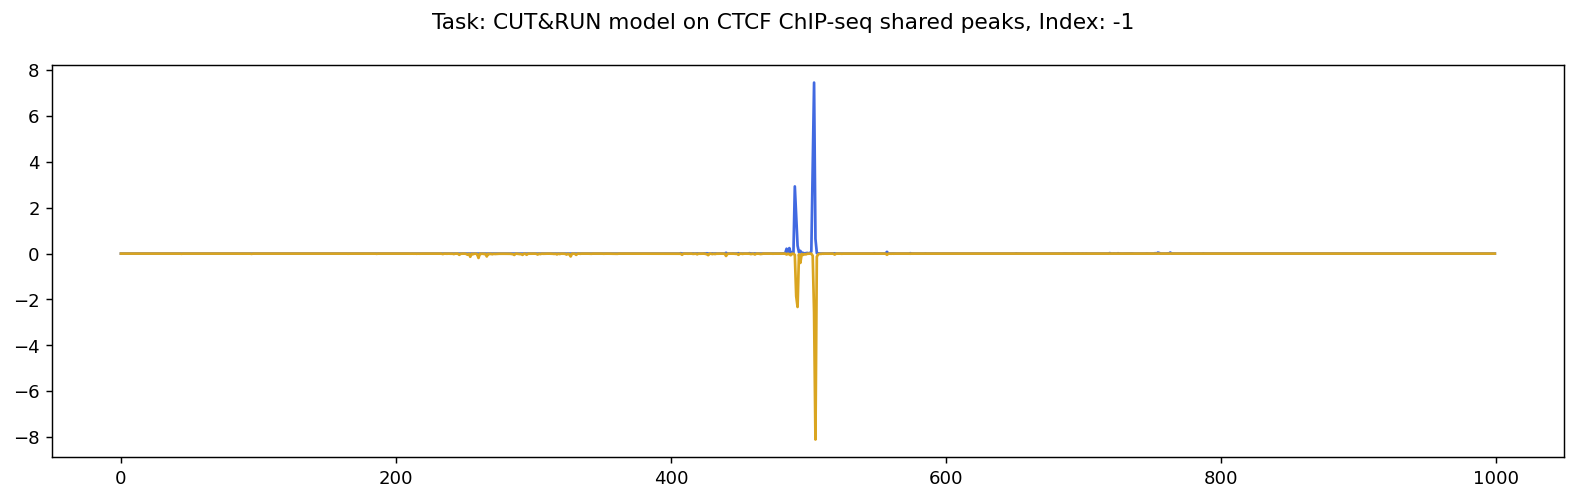

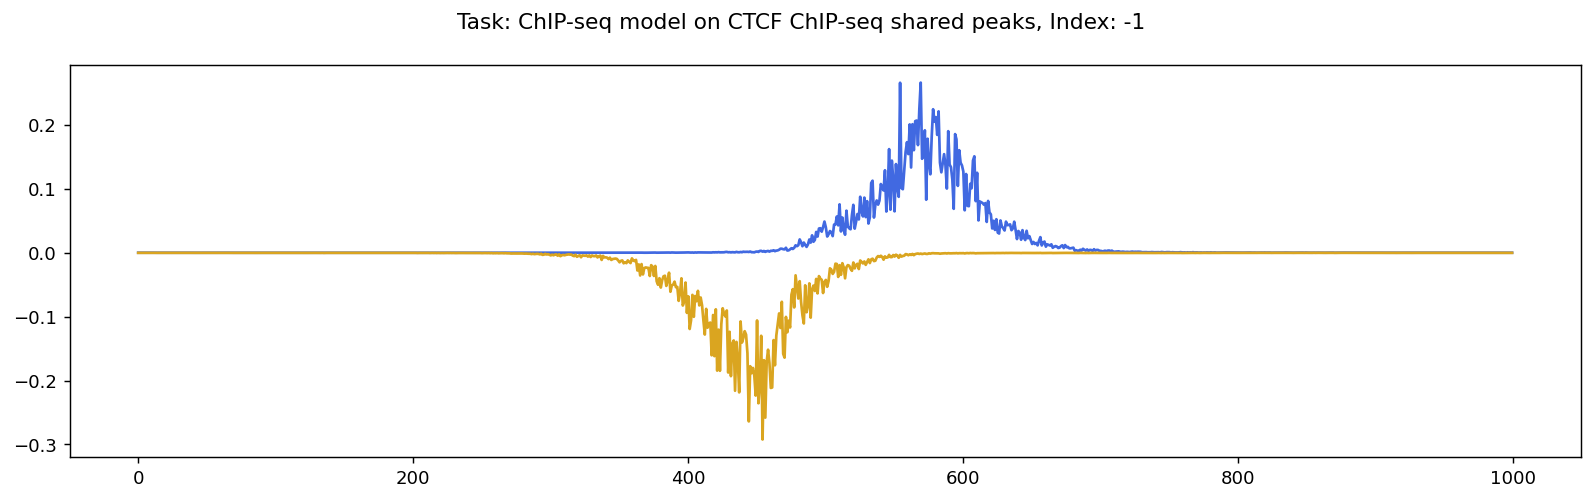

In [146]:
plot_from_model_dicts(ranked_jsd_shared_pred_profs_chip, ranked_jsd_shared_pred_counts_chip, list(range(2)), 
                      'CTCF ChIP-seq shared peaks')
plot_from_model_dicts(ranked_jsd_shared_pred_profs_chip, ranked_jsd_shared_pred_counts_chip, list(range(-2,0)), 
                      'CTCF ChIP-seq shared peaks')

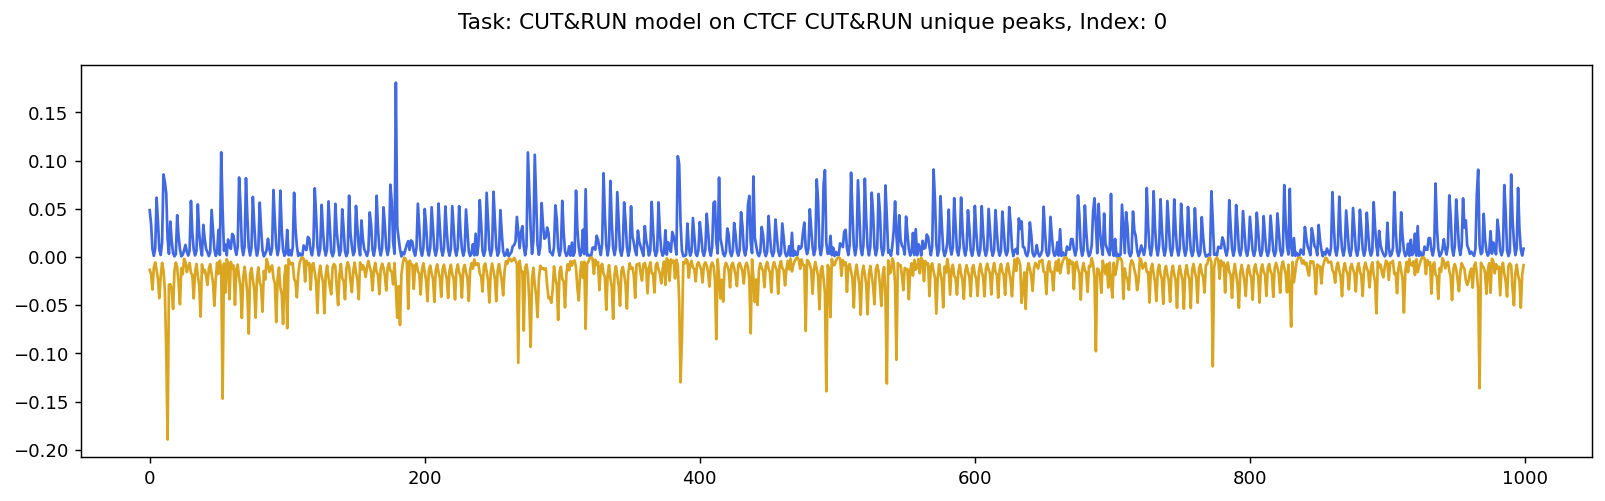

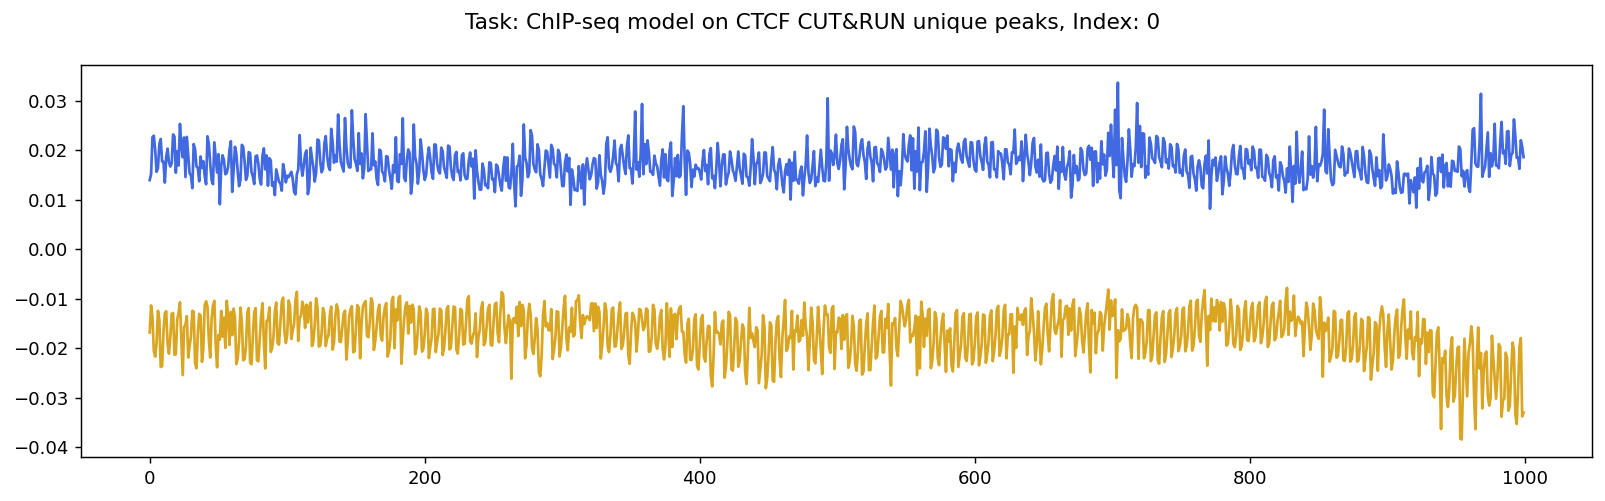

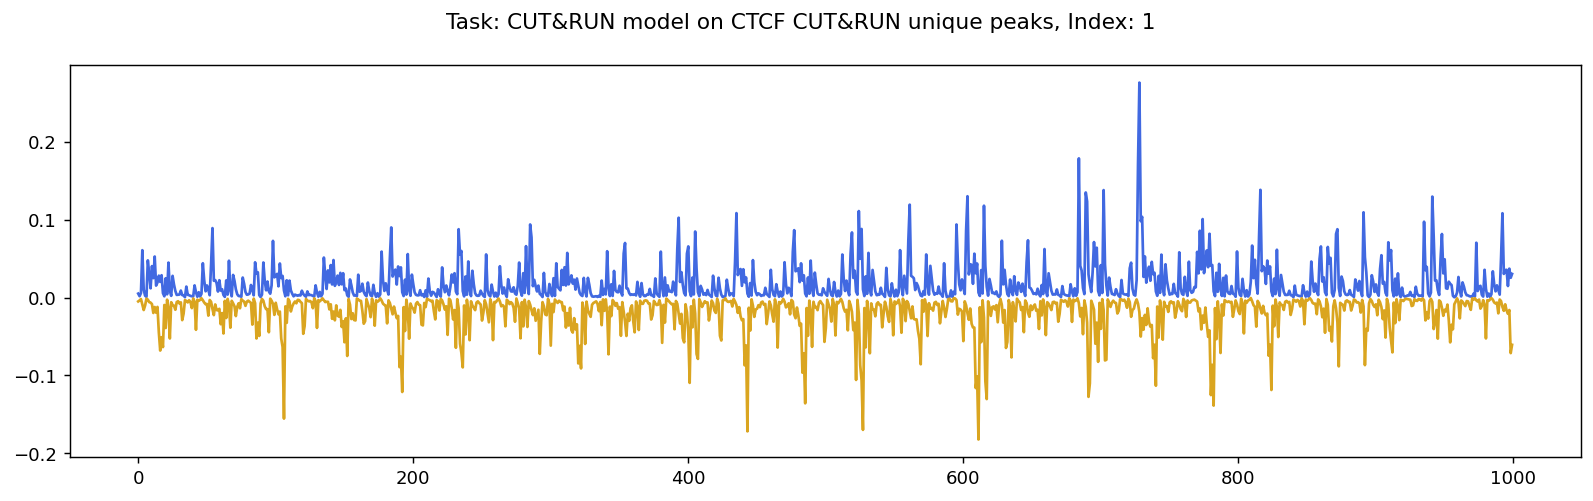

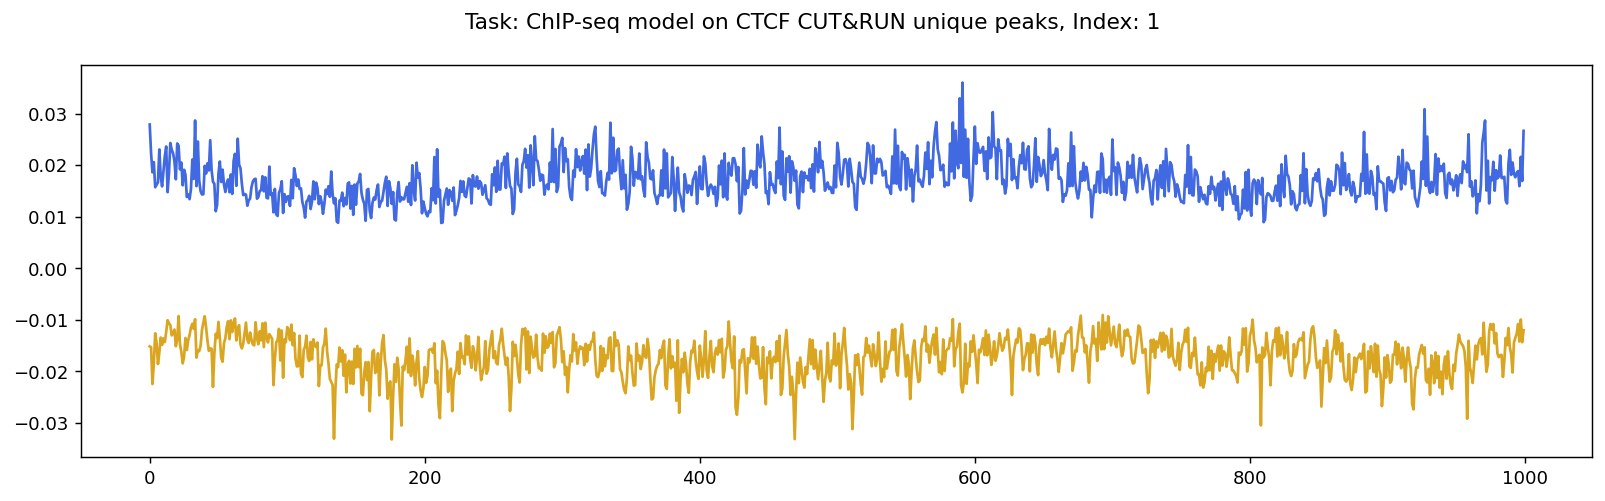

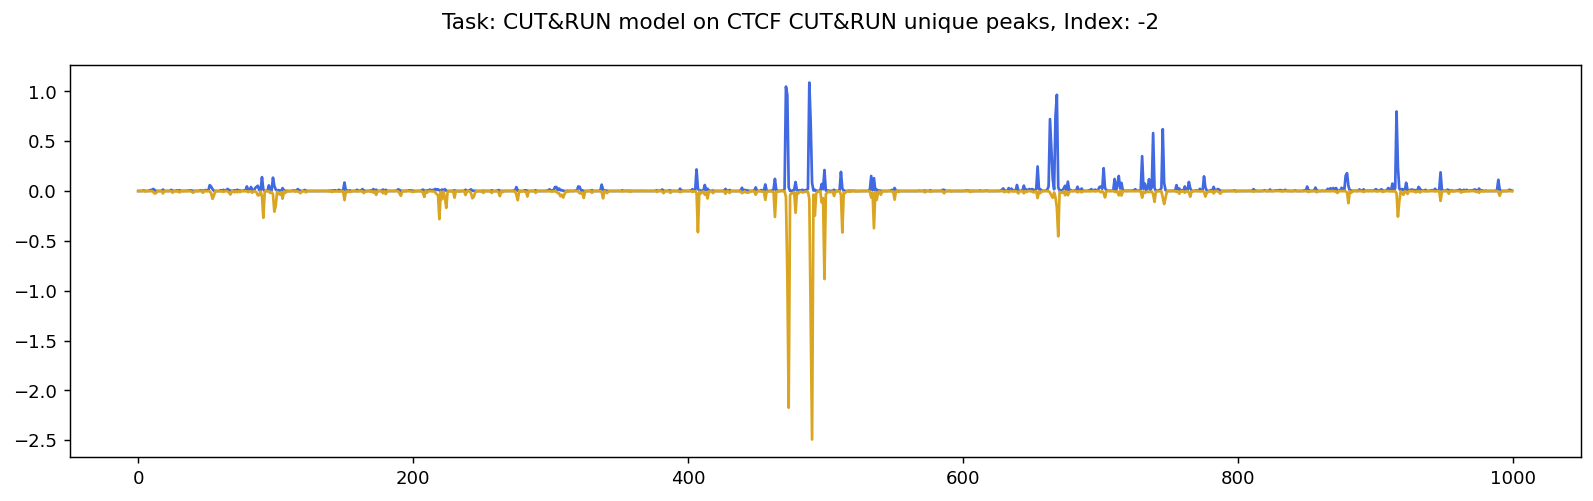

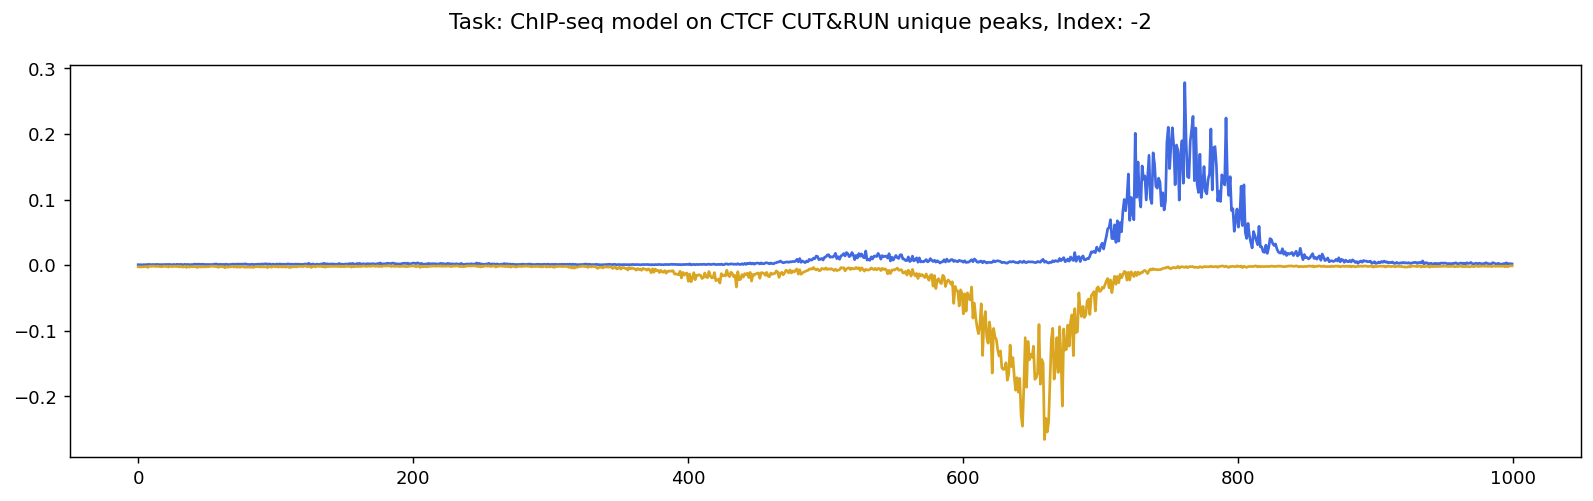

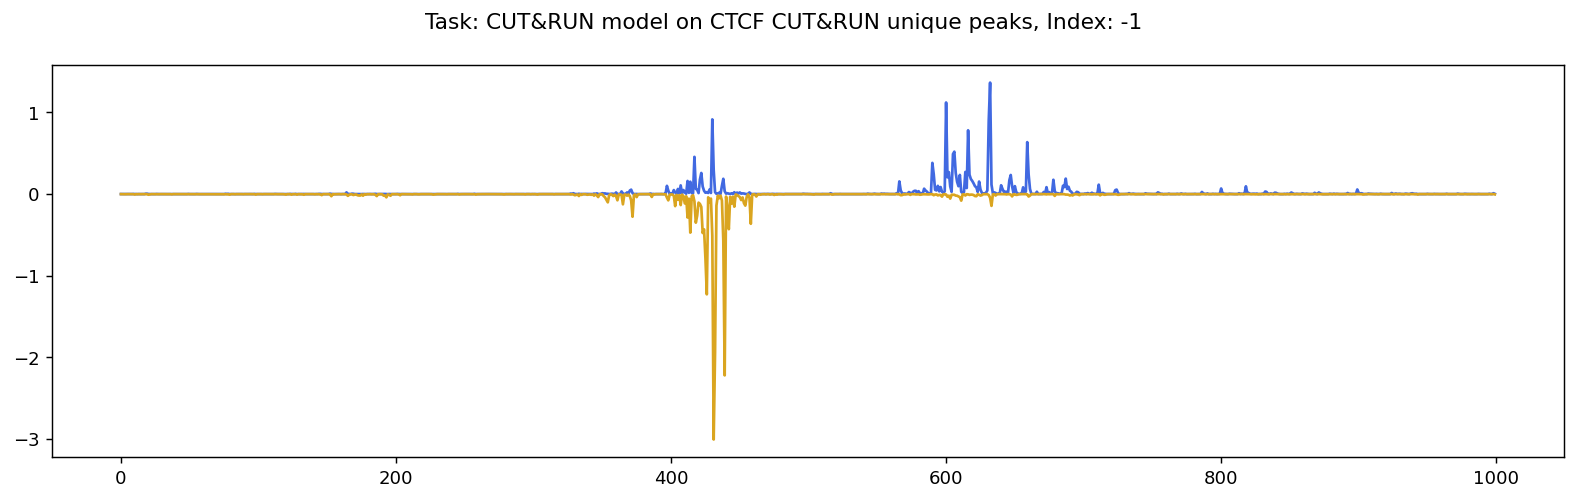

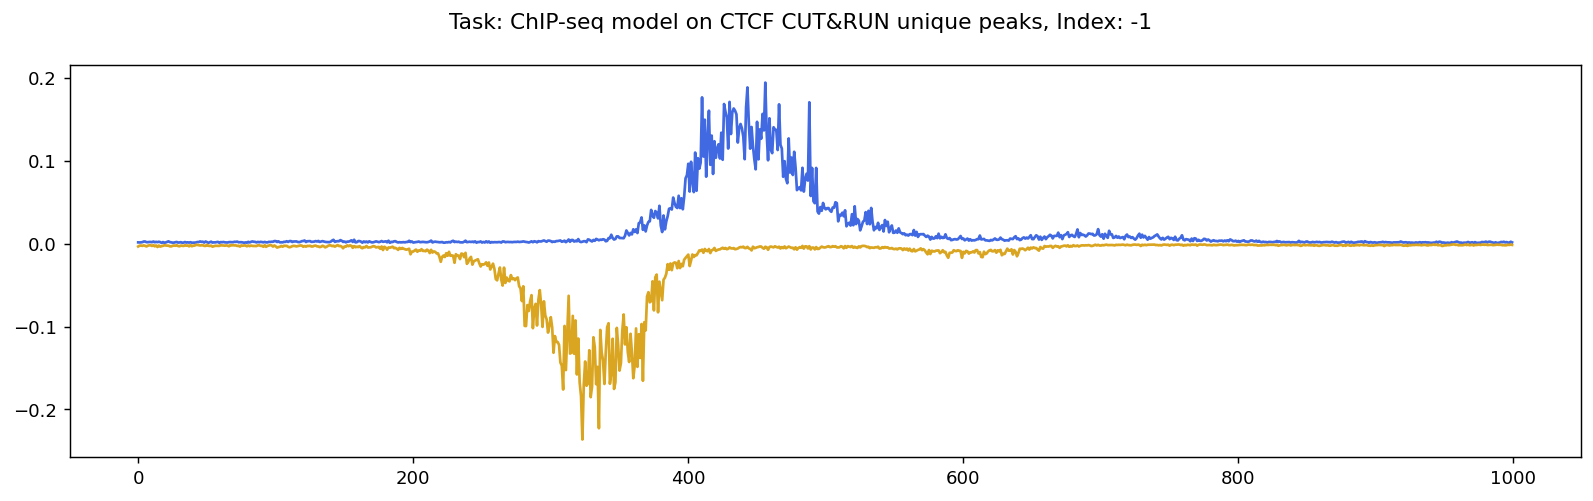

In [148]:
plot_from_model_dicts(ranked_jsd_unique_pred_profs_cut, ranked_jsd_unique_pred_counts_cut, list(range(2)), 
                      'CTCF CUT&RUN unique peaks')
plot_from_model_dicts(ranked_jsd_unique_pred_profs_cut, ranked_jsd_unique_pred_counts_cut, list(range(-2,0)), 
                      'CTCF CUT&RUN unique peaks')

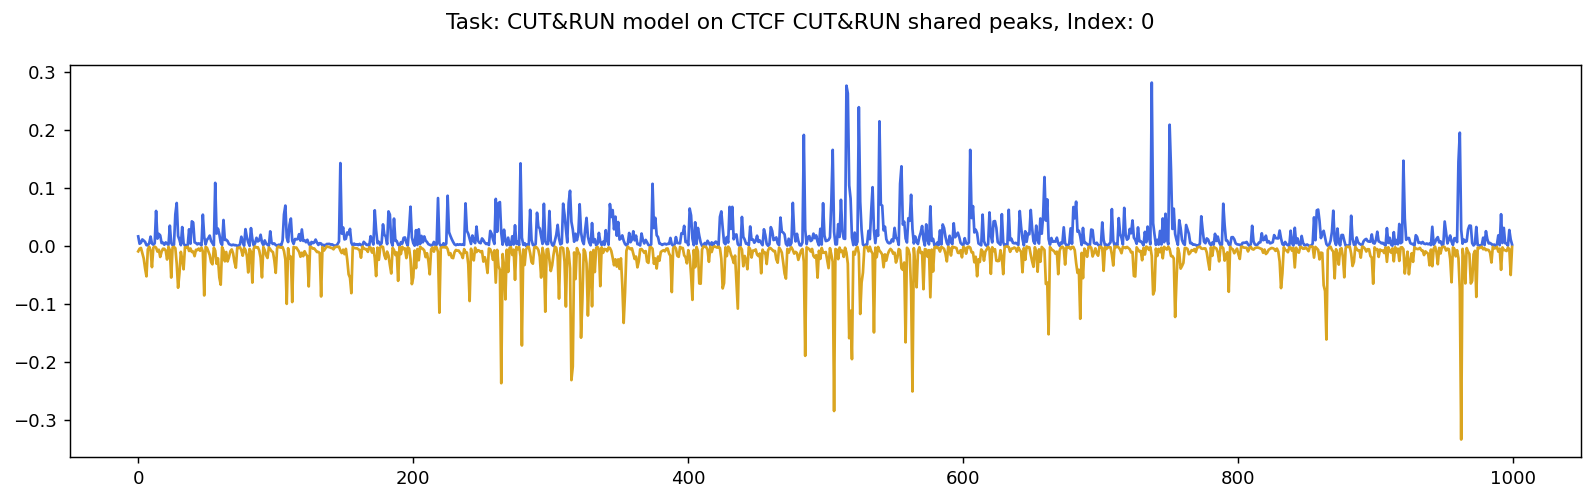

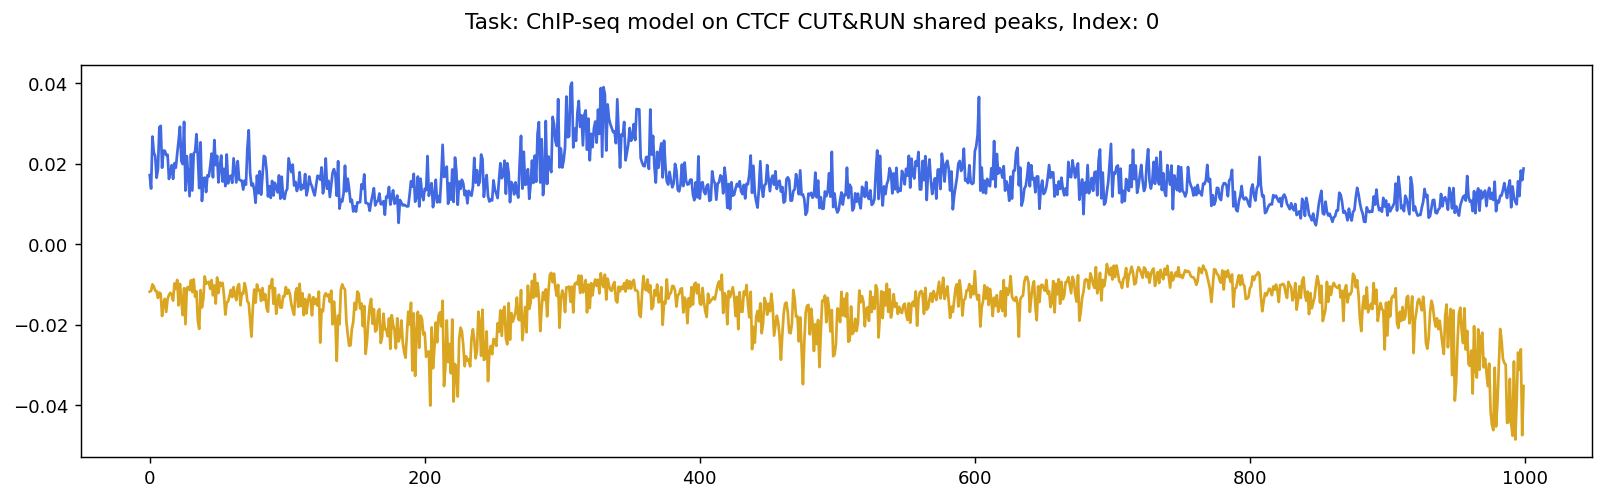

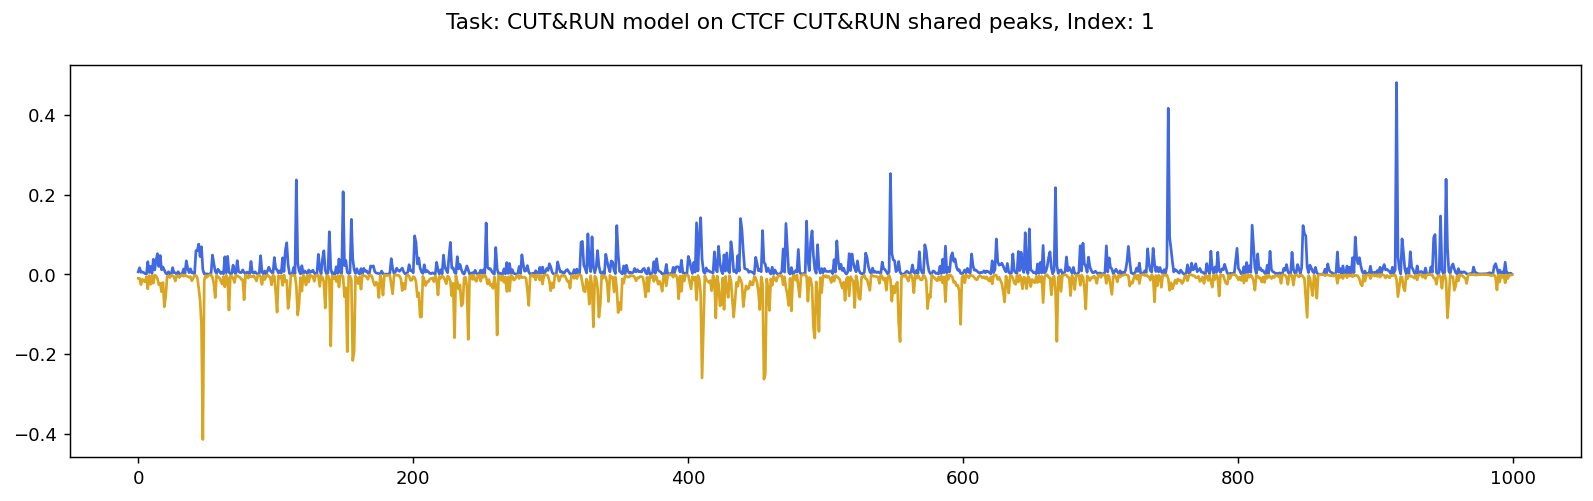

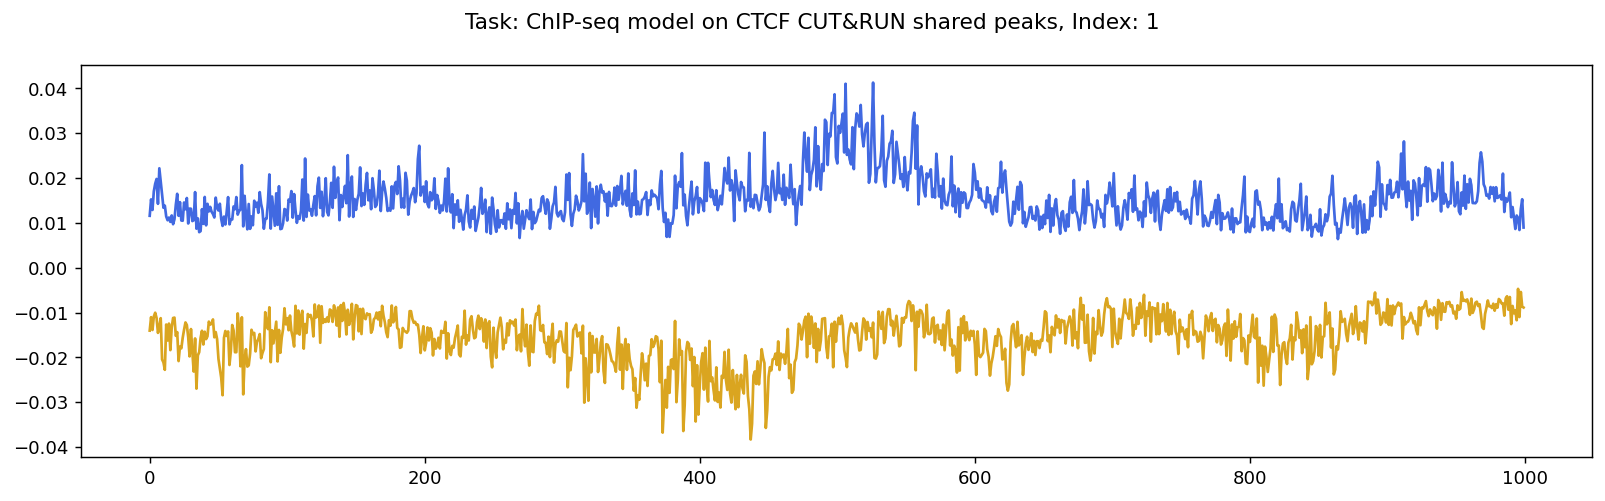

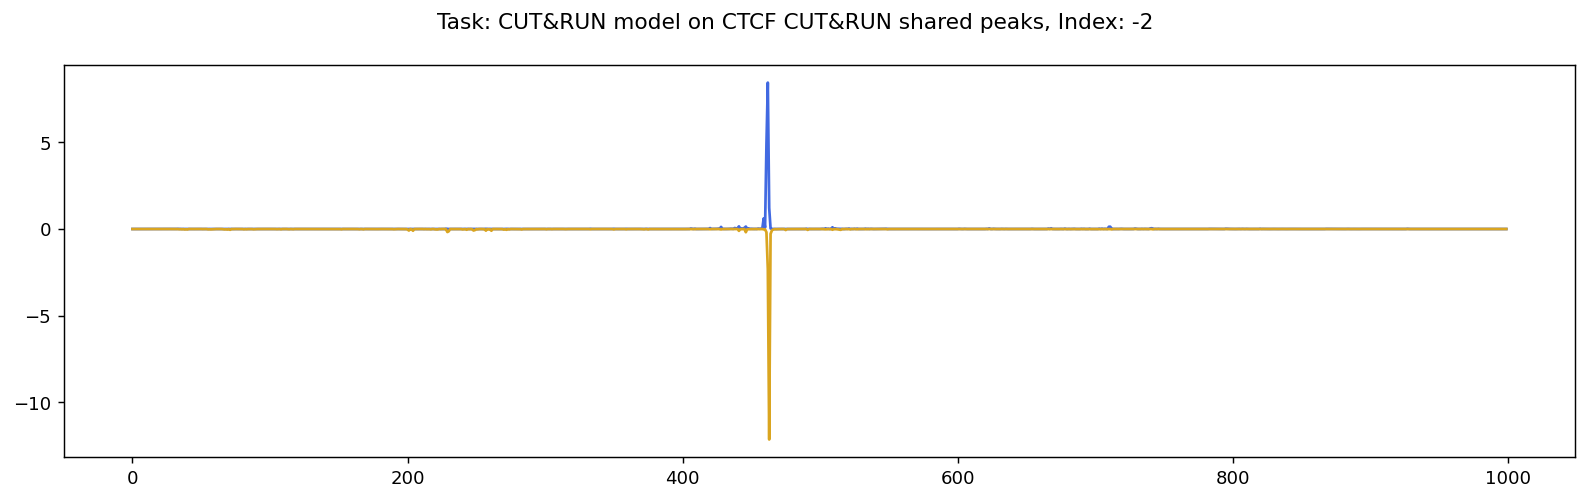

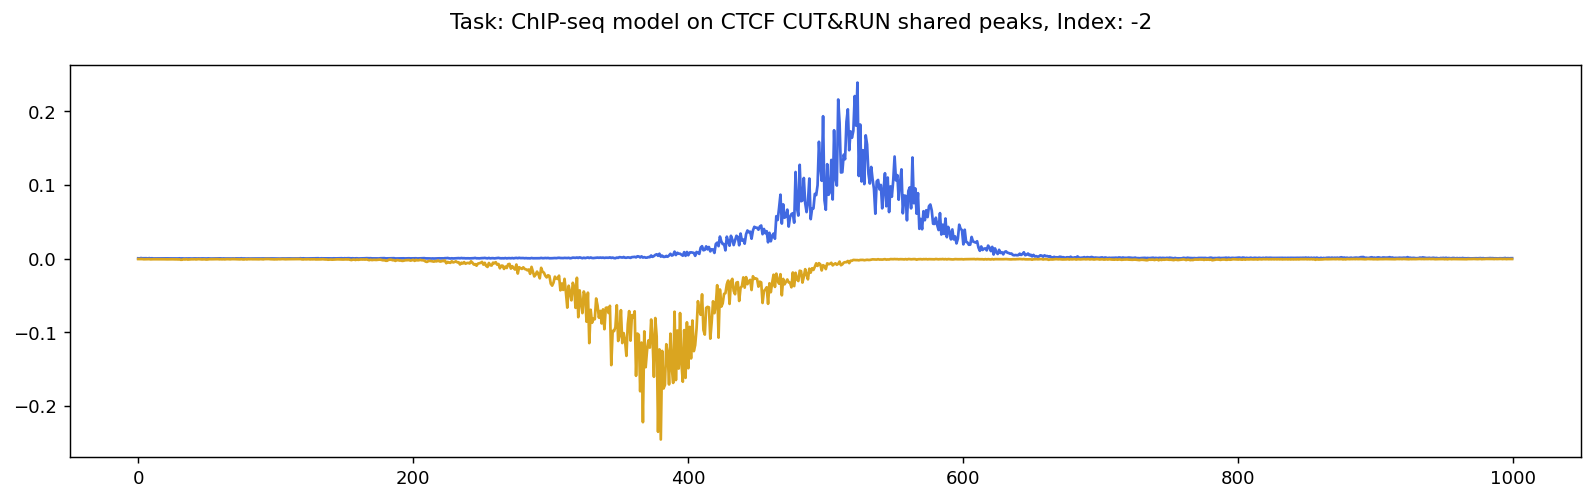

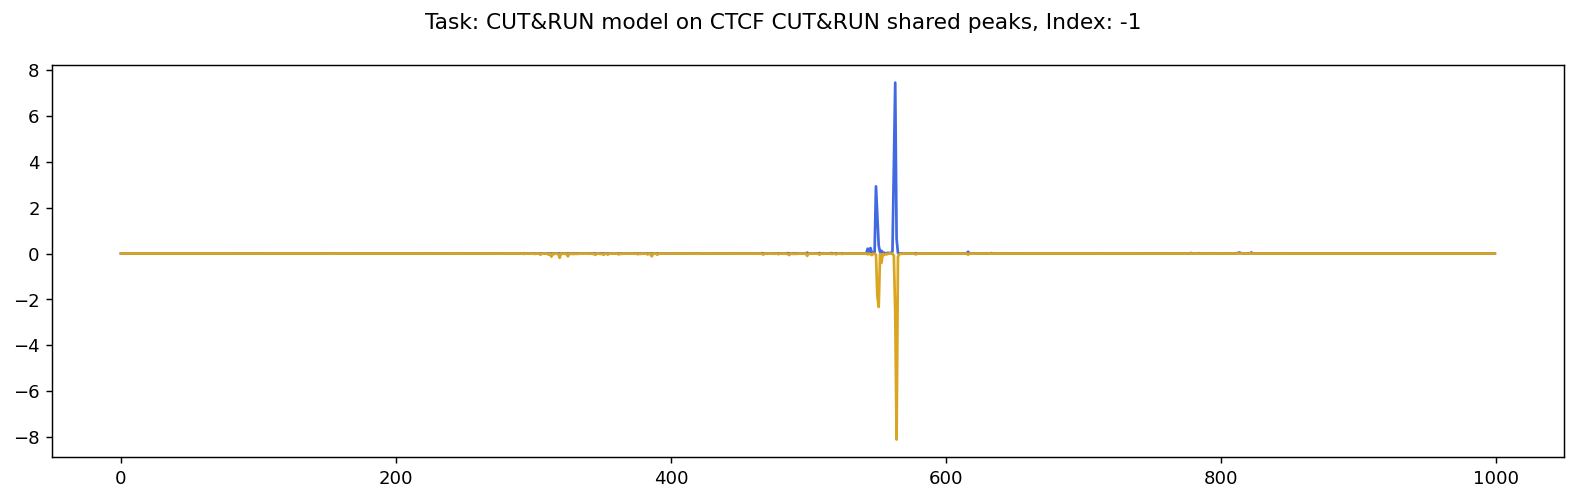

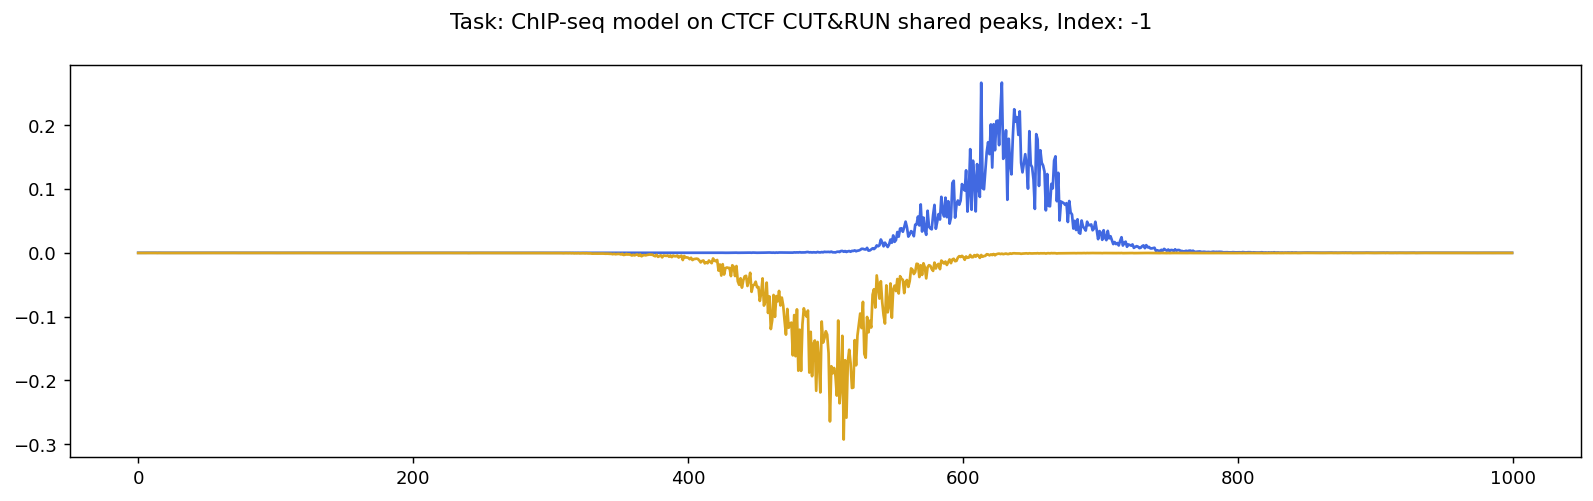

In [149]:
plot_from_model_dicts(ranked_jsd_shared_pred_profs_cut, ranked_jsd_shared_pred_counts_cut, list(range(2)), 
                      'CTCF CUT&RUN shared peaks')
plot_from_model_dicts(ranked_jsd_shared_pred_profs_cut, ranked_jsd_shared_pred_counts_cut, list(range(-2,0)), 
                      'CTCF CUT&RUN shared peaks')

## If the predictions look the same, do the importance scores also look the same? (are the same signals being identified as being important?) 

## If the predictions are different, what might explain that difference? The TA motif? DNase/ATAC/histone marks?

### Compare importance scores for peaks with low/high JSD

In [188]:
# load in all the hyp_scores into a dictionary called hyp_scores
# load in all coords  into a dictionary called coords (for purposes of indexing later)
path = '/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/ctcf_pipeline_mar22/'
hyp_scores = {}
coords = {}
for p in glob.glob(path + '*'):
    imp_tuple = import_shap_scores(p + '/shap_scores',
                                    hyp_score_key='hyp_scores', center_cut_size=400, remove_non_acgt=False)
    hyp_scores[p[len(path):]] = imp_tuple[0]
    coords[p[len(path):]] = pd.DataFrame(imp_tuple[3], columns=['chrom','start','end'])  # coords should be a DataFrame

Importing SHAP scores: 100%|████████████████████| 62/62 [00:01<00:00, 55.93it/s]


In [398]:
hyp_scores.keys()

dict_keys(['cut_model_cut_shared_peaks', 'chip_model_cut_shared_peaks', 'cut_model_cut_unique_peaks', 'chip_model_cut_unique_peaks', 'chip_model_chip_unique_peaks', 'cut_model_chip_shared_peaks', 'cut_model_chip_unique_peaks', 'chip_model_chip_shared_peaks'])

In [206]:
dups = {}   # dict of boolean arrays indicating whether or not this was duplicated
for key in coords.keys():
    dups[key] = coords[key].duplicated()
    hyp_scores[key] = hyp_scores[key][dups[key]]   # remove duplicates in hyp_scores

In [261]:
# for purposes of dropping duplicated/indexing, load in all the peak subsets into dictionary called peaks
path = '/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/'
peaks = {}
for p in list( set(glob.glob(path + 'CTCF*')) - set(glob.glob(path + '*preds')) \
              - set(glob.glob(path + '*pipeline*')) - set(glob.glob(path + '*chr*'))):
    peaks[p[len(path):]] = import_peak_table([p]).drop(0, axis=0).reset_index()
# i messed up 1st row of hypscores so delete the first peak here ig rip i need to fix this later lmao

In [211]:
import viz_sequence
from viz_sequence import plot_weights

In [221]:
subsets = {'chip_unique': ['cut_model_chip_unique_peaks', 'chip_model_chip_unique_peaks'],
           'chip_shared': ['cut_model_chip_shared_peaks', 'chip_model_chip_shared_peaks'],
           'cut_unique': ['cut_model_cut_unique_peaks', 'chip_model_cut_unique_peaks'],
           'cut_shared': ['cut_model_cut_shared_peaks', 'chip_model_cut_shared_peaks'] }   # group em by peak subset, and keep the model pairs

In [222]:
inds = {'chip_unique': ranked_jsd_unique_chip_inds,
        'chip_shared': ranked_jsd_shared_chip_inds,
        'cut_unique': ranked_jsd_unique_cut_inds,
        'cut_shared': ranked_jsd_shared_cut_inds }

In [ ]:
# can check that coords and peaks match:
# coords['cut_model_chip_unique_peaks'][dups['cut_model_chip_unique_peaks']].reset_index().iloc[ranked_jsd_unique_chip_inds]
# peaks['chip_unique_no_cut'].iloc[YOUR CHOICE]

In [231]:
hyp_scores_low_jsd = {}
for key in subsets.keys():
    hyp_scores_low_jsd[key] = list(hyp_scores[i][inds[key][:2]] for i in subsets[key])  
# ok literally idk how to document this just understand that it works and ignore the nested indexing PLS

hyp_scores_high_jsd = {}
for key in subsets.keys():
    hyp_scores_high_jsd[key] = list(hyp_scores[i][inds[key][-2:]] for i in subsets[key])  
# ok literally idk how to document this just understand that it works and ignore the nested indexing PLS

In [401]:
len(hyp_scores_low_jsd['chip_unique'])

2

chip_unique


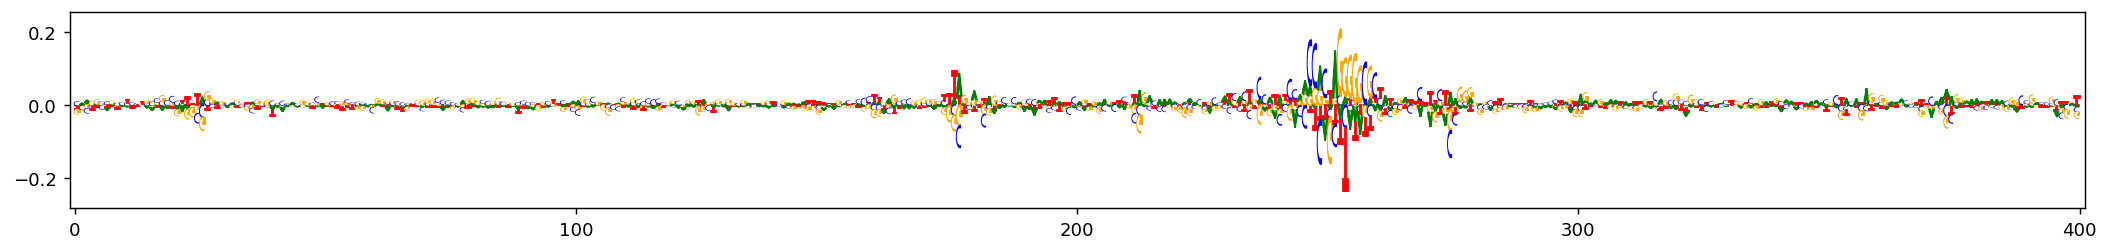

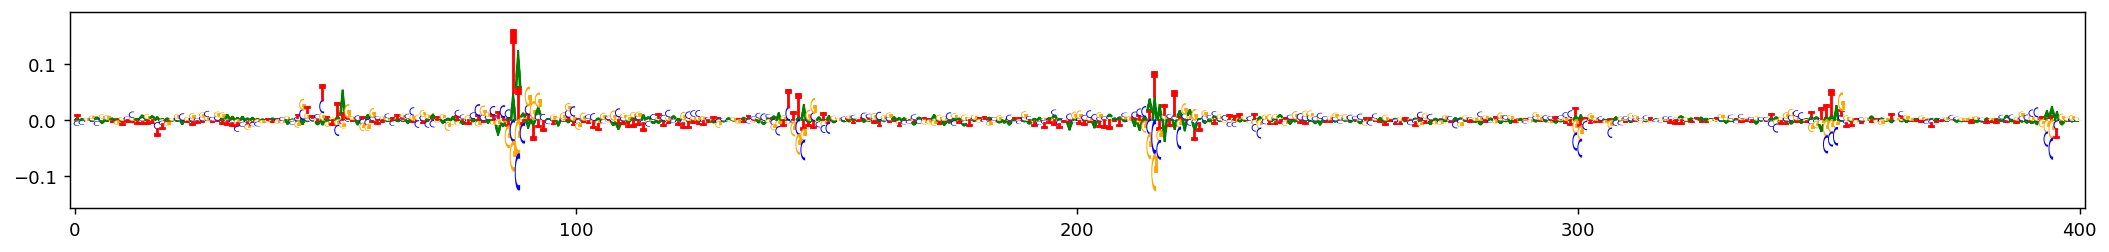

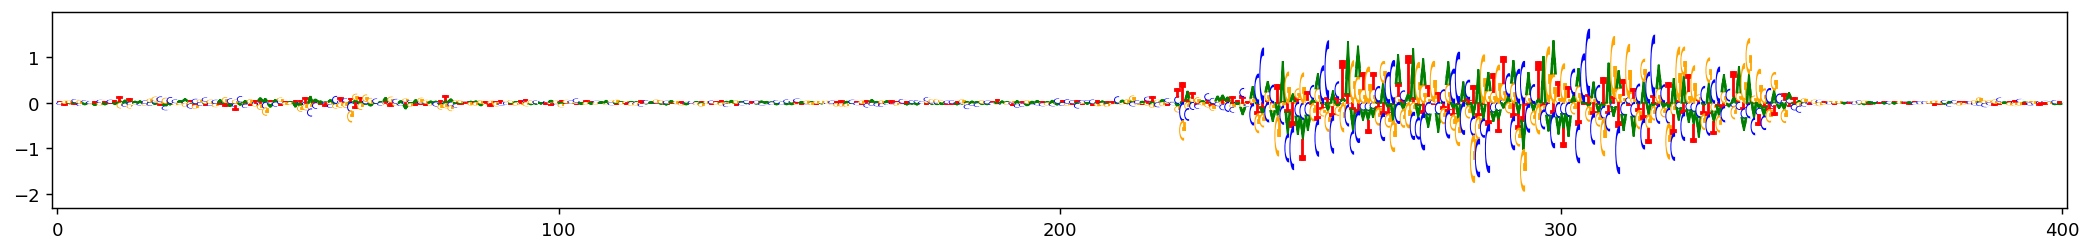

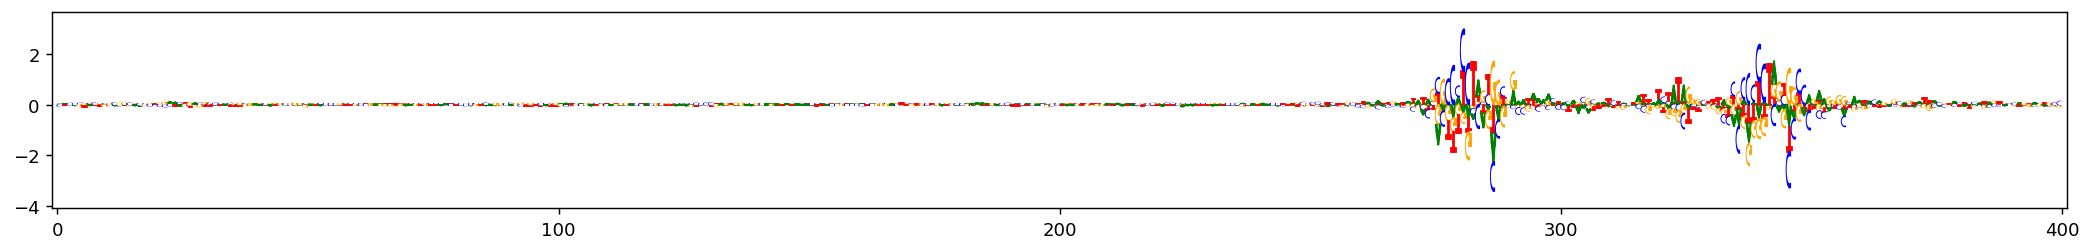




chip_shared


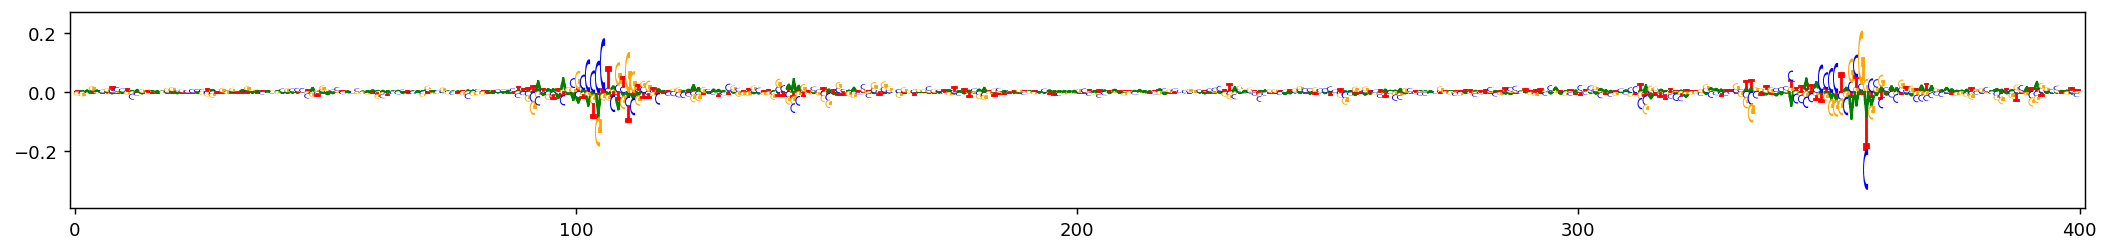

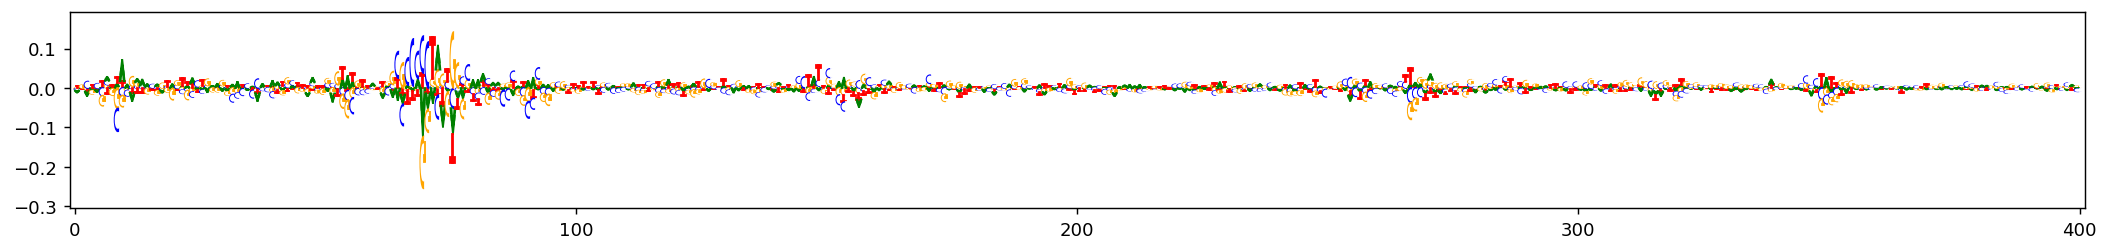

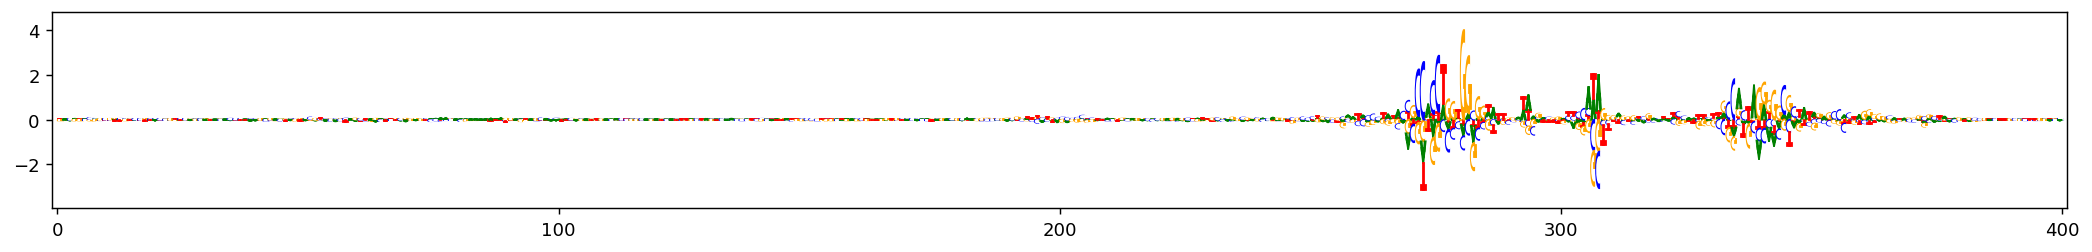

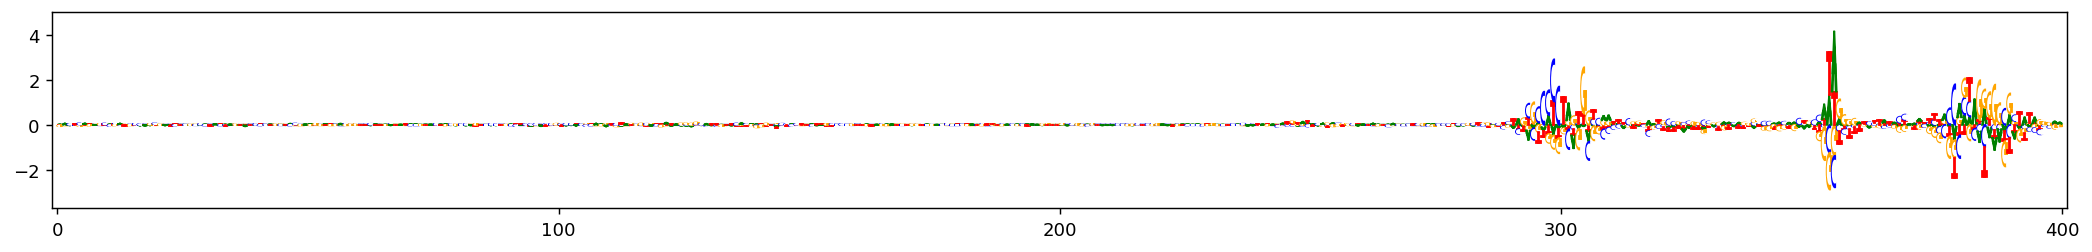




cut_unique


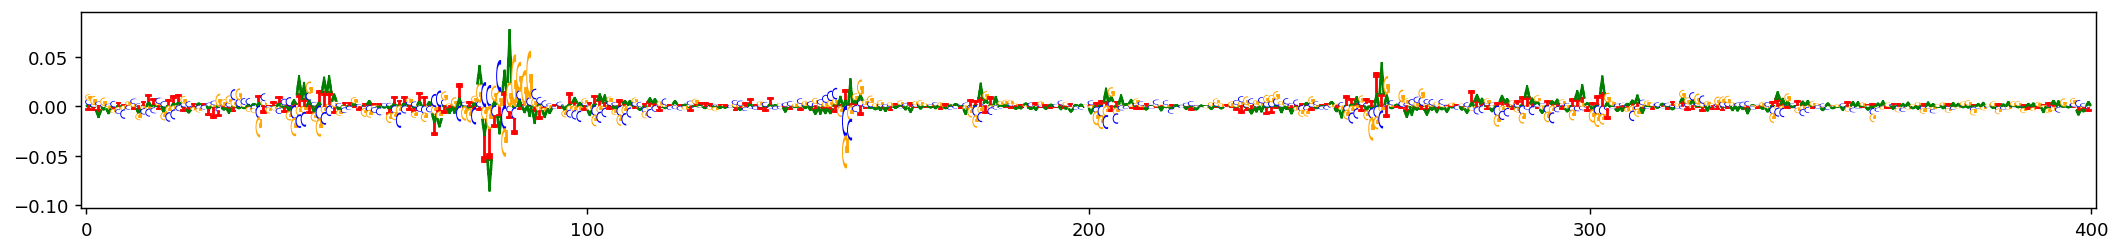

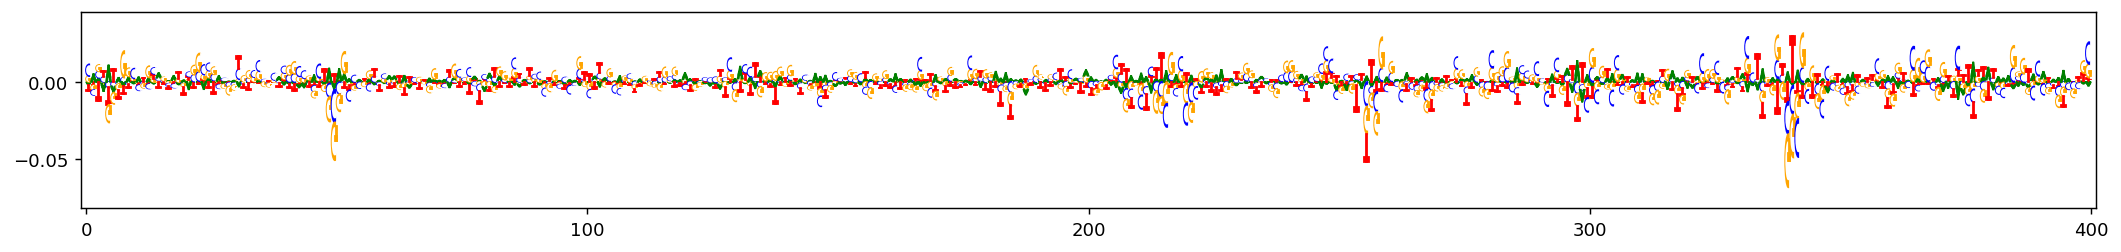

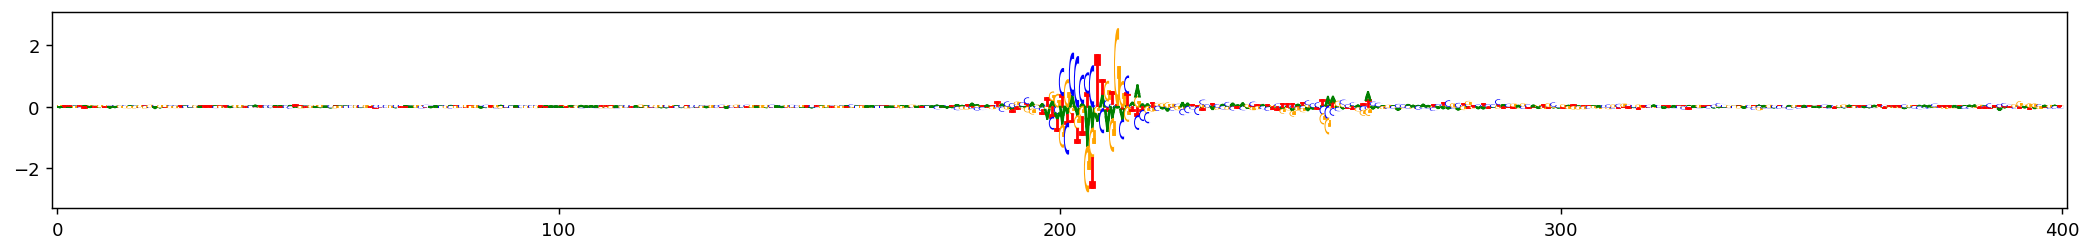

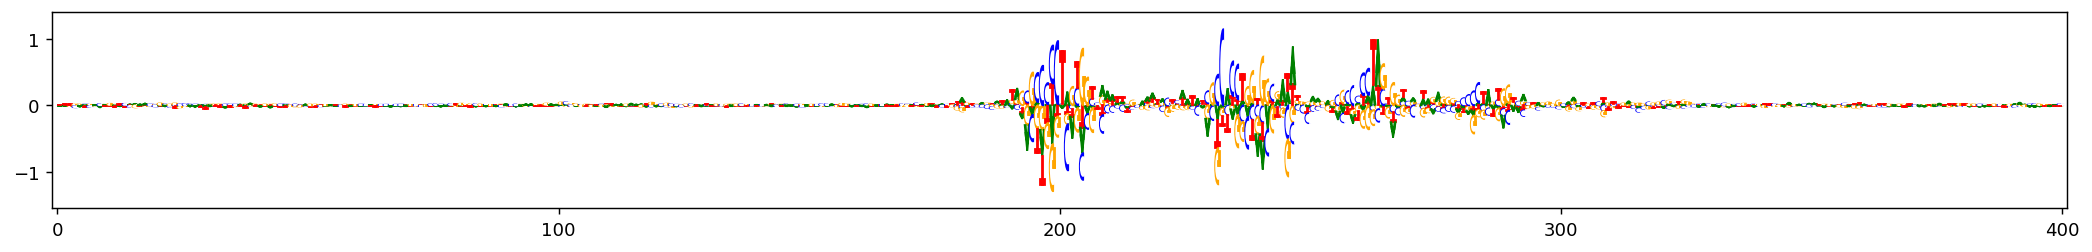




cut_shared


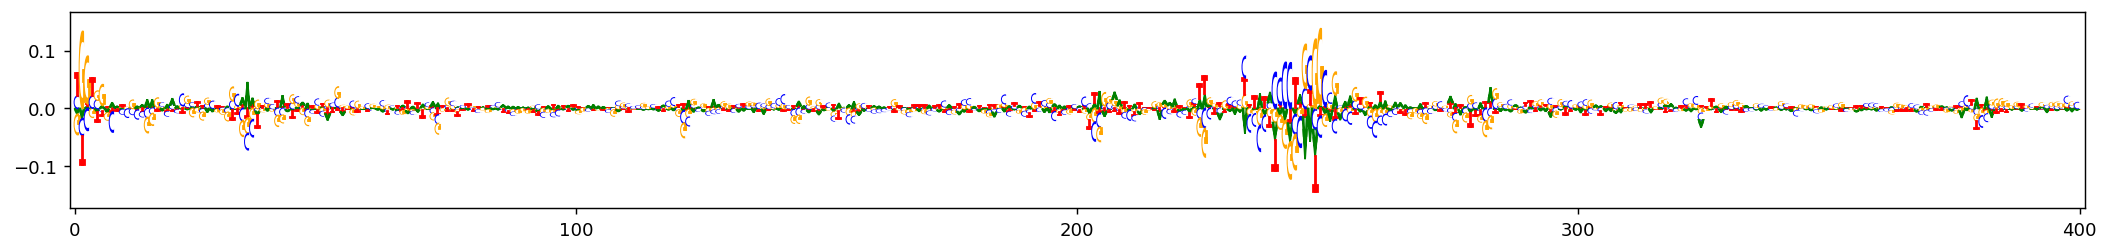

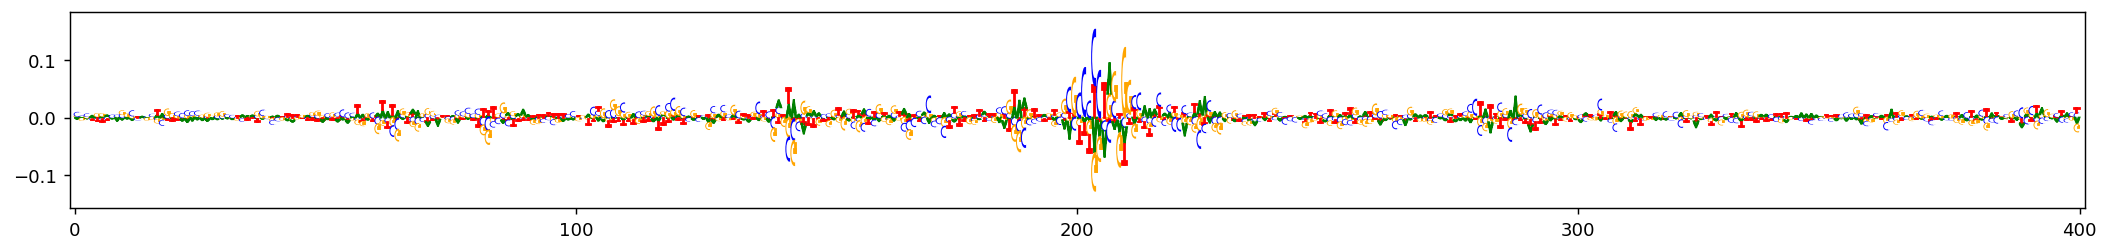

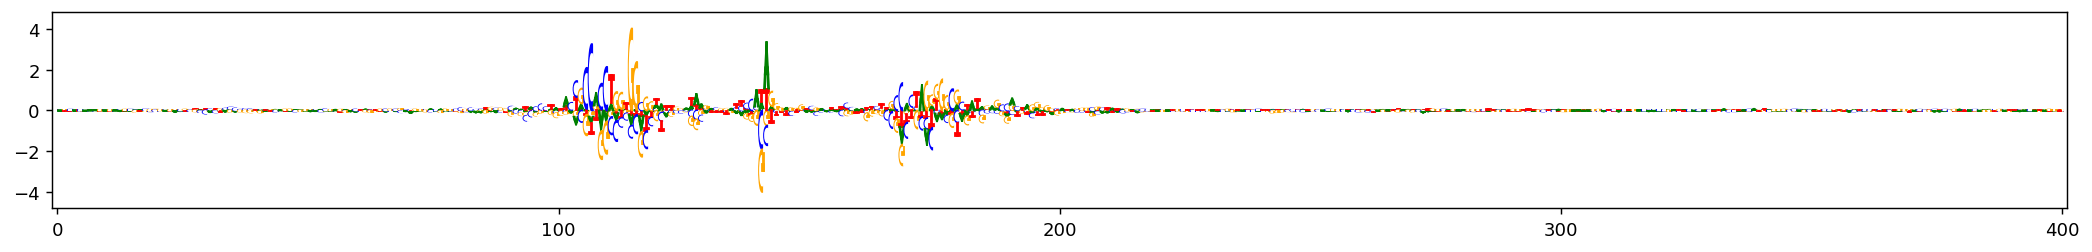

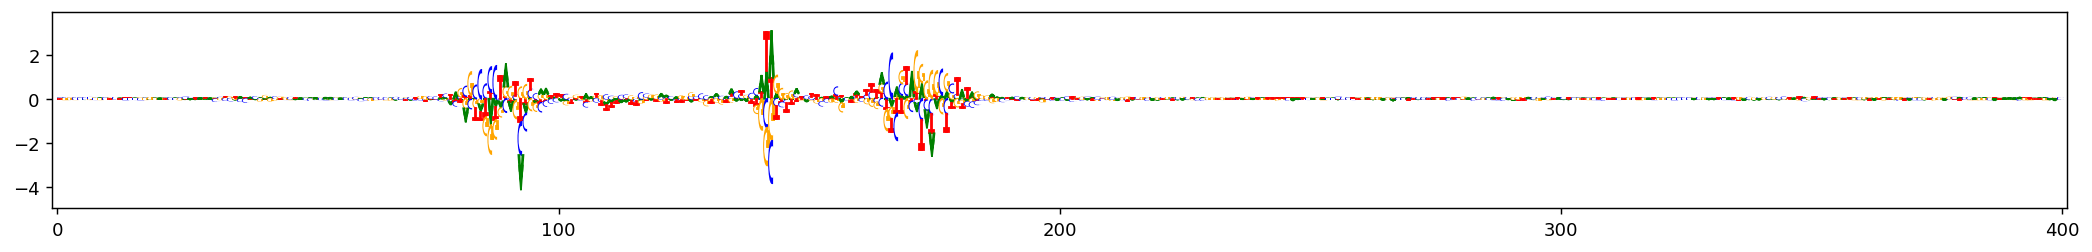

In [304]:
# plot importance scores for the 2 highest and 2 lowest JSD peaks
for key in inds.keys():
    print(key)
    # lowest JSD
    plot_weights(hyp_scores_low_jsd[key][0][0], subticks_frequency=100)
    
    # 2nd lowest JSD
    plot_weights(hyp_scores_low_jsd[key][0][1], subticks_frequency=100)
    
    # highest JSD
    plot_weights(hyp_scores_high_jsd[key][0][1], subticks_frequency=100)
    
    # 2nd highest JSD
    plot_weights(hyp_scores_high_jsd[key][0][0], subticks_frequency=100)
    
    print('\n\n')

### Check motif distributions

In [345]:
# load motif hits
path = '/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_2/ctcf_tfm_results_mar23/'
hits = {}
for key in coords.keys():
    hits[key] = pd.read_csv(f'{path}{key}/tfm_matches.bed', sep='\t', header=None)
    hits[key].drop(list(range(6,16)), axis=1, inplace=True)
    hits[key].columns = ['chrom','start','end','motif','strand','peak']

In [384]:
hits_20perc = {}
hits_80perc = {}

for key in hits.keys():
    if 'cut_shared' in key:
        inds_key = 'cut_shared'
    elif 'cut_unique' in key:
        inds_key = 'cut_unique'
    elif 'chip_shared' in key:
        inds_key = 'chip_shared'
    else:
        inds_key = 'chip_unique'
        
    inds_20perc = inds[inds_key][: int(len(inds[inds_key]) * 0.2)]
    inds_80perc = inds[inds_key][int(len(inds[inds_key]) * 0.8): ]
    hits_20perc[key] = hits[key].loc[np.isin(hits[key].peak - 1, inds_20perc)]   # minus 1 because of indexing issues
    hits_80perc[key] = hits[key].loc[np.isin(hits[key].peak - 1, inds_80perc)]

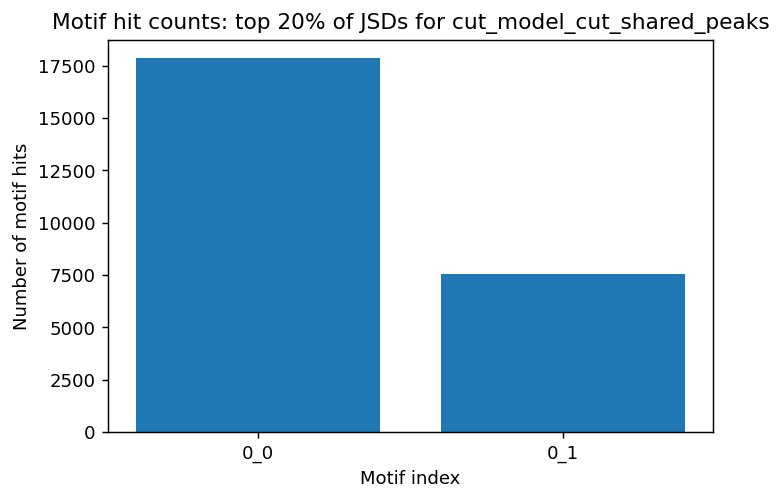

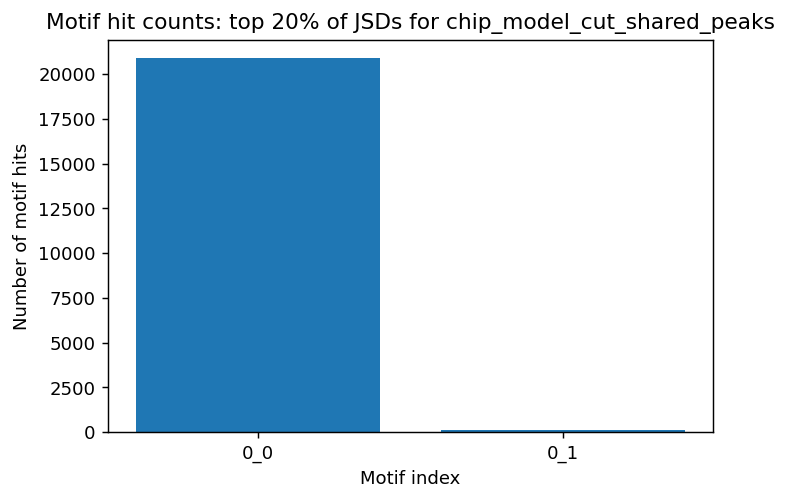

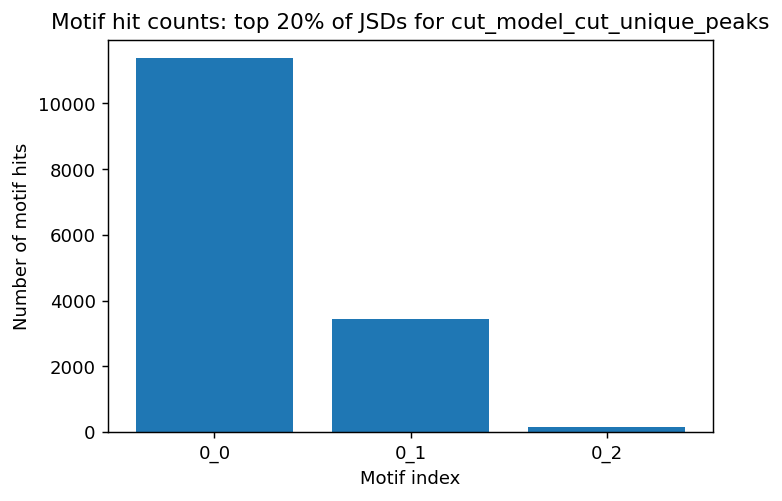

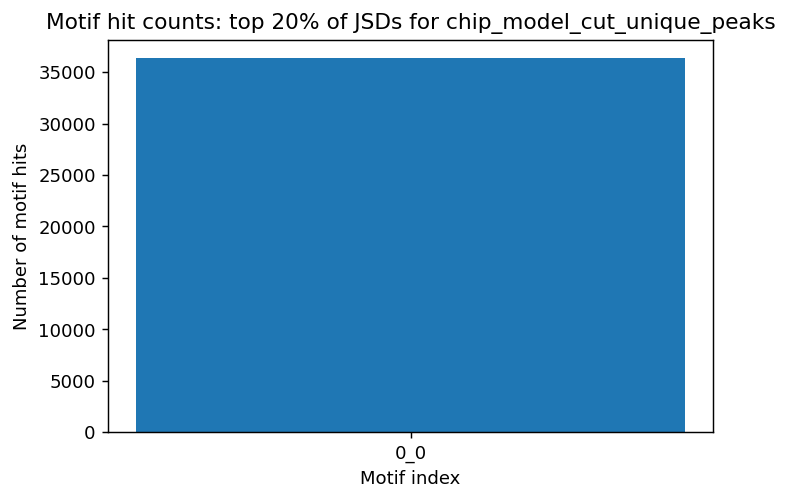

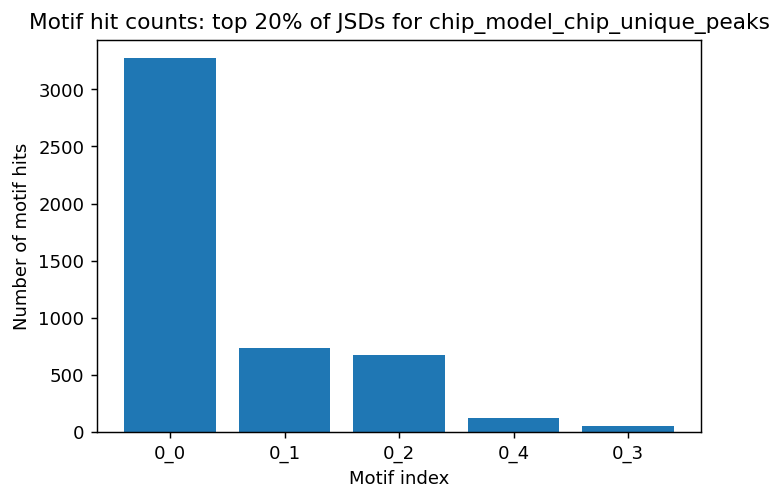

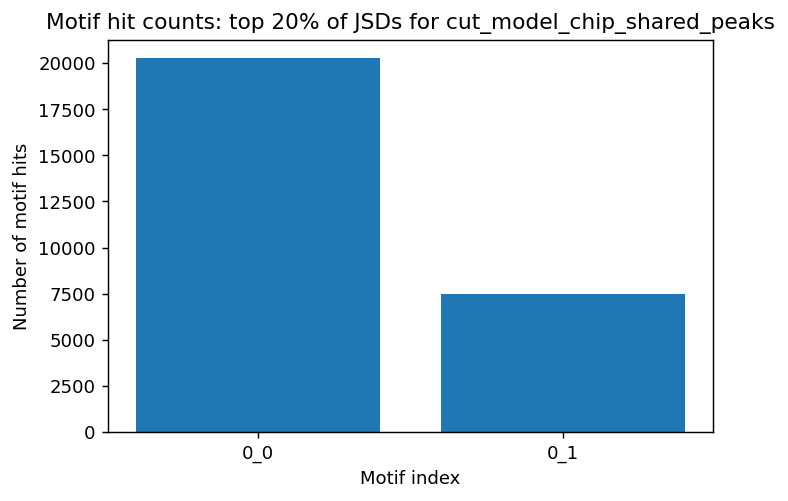

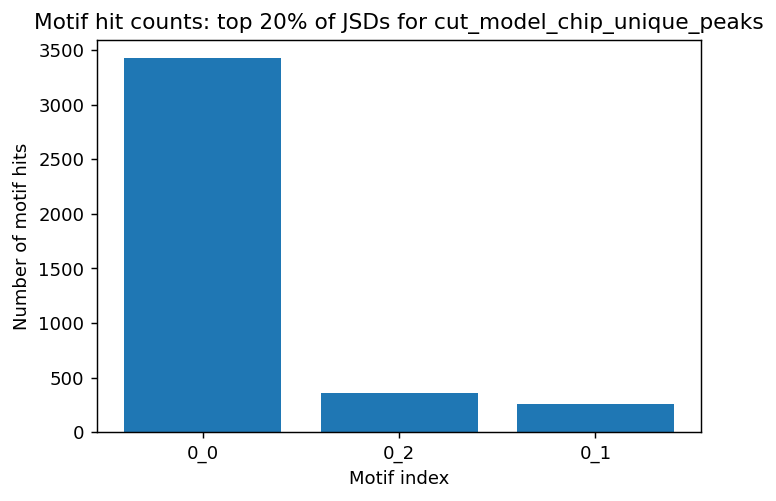

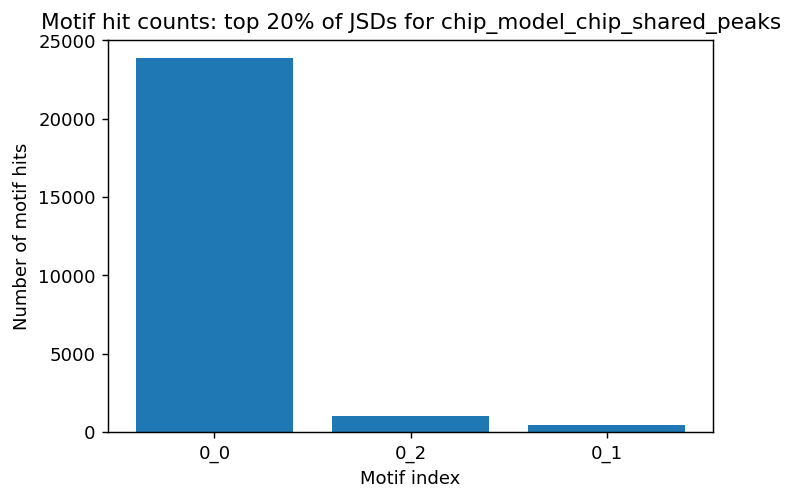

In [397]:
# motif hit counts bar plots
# for key in hits_20perc.keys():
#     fig, ax = plt.subplots(1,1)
#     ax.bar(pd.value_counts(hits_20perc[key].motif).keys(), pd.value_counts(hits_20perc[key].motif).values)
#     plt.xlabel('Motif index')
#     plt.ylabel('Number of motif hits')
#     plt.title(f'Motif hit counts: bottom 20% of JSDs for {key}')
    
for key in hits_80perc.keys():
    fig, ax = plt.subplots(1,1)
    ax.bar(pd.value_counts(hits_80perc[key].motif).keys(), pd.value_counts(hits_80perc[key].motif).values)
    plt.xlabel('Motif index')
    plt.ylabel('Number of motif hits')
    plt.title(f'Motif hit counts: top 20% of JSDs for {key}')

### Intersect with genomic features